## Notebook to make figures for MNIST compatible in paper

In [2]:
%matplotlib inline 
import os
import gc
import sys
import glob
import json
import math
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.models import Model

import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
from sklearn.manifold import TSNE
libdir = '/home/tkurihana/scratch-midway2/clouds/src_analysis/lib_hdfs'
sys.path.insert(1,os.path.join(sys.path[0],libdir))
from analysis_lib import get_rand_colors

In [4]:
from PIL import Image

### Load MNIST dataset

In [5]:
# datast mnist
from tensorflow.keras.datasets.mnist import load_data

In [6]:
_, (x_test, y_test) = load_data(path='./mnist.npz')

In [7]:
x_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [8]:
np.arange(0,360,5)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255,
       260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320,
       325, 330, 335, 340, 345, 350, 355])

---------------------
### 1.  Visualize image
Example is "7", four original, rotate and the output figure should be plotted for L2, best CLF and best RI autoencoder
- L2: original3 ??
- CLF: 62538901
- RI: 66021965

In [9]:
def rotate_fn(images, angles):
    """
    images : 4d tensor [batch, height, width channel]
      original oprion - nearest. Additional: biilnear
    """
    rotated_tensor_images = tf.contrib.image.transform(
      images,
      tf.contrib.image.angles_to_projective_transforms(
        angles, tf.cast(tf.shape(images)[1], tf.float32), 
            tf.cast(tf.shape(images)[2], tf.float32)
        ),
    )
     #interpolation='BILINEAR'
    return rotated_tensor_images

In [10]:
def resize_image_fn(imgs,height=32, width=32):
    """Resize images from (#batch,H',W',C) --> (#batch,H,W,C)
    """
    reimgs = tf.image.resize_images(imgs, (height, width))
    return reimgs

In [11]:
def load_latest_model(model_dir, mtype):
    #TODO add restart model dir and restart argument?
    latest = 0, None
    # get trained wegiht 
    for m in os.listdir(model_dir):
        if ".h5" in m and mtype in m:
            epoch = int(m.split("-")[1].replace(".h5", ""))
            latest = max(latest, (epoch, m))

    epoch, model_file = latest

    if not os.listdir(model_dir):
        raise NameError("no directory. check model path again")

    print(" Load {} at {} epoch".format(mtype, epoch))
    model_def = model_dir+'/'+mtype+'.json'
    model_weight = model_dir+'/'+mtype+'-'+str(epoch)+'.h5'
    with open(model_def, "r") as f:
        model = tf.keras.models.model_from_json(f.read())
    model.load_weights(model_weight)
    return model

- load model first 

In [13]:
l2_basedir = '/project2/foster/clouds/metrics_20200208/metrics'

In [35]:
clf_basedir = "/project2/foster/clouds/metrics_20200208/metrics"

In [36]:
ri_basedir = '/home/tkurihana/rotate_invariant/stepbystep/transform'

In [12]:
nri_basedir = '/home/tkurihana/clouds/analysis_MNIST'

In [54]:
expnames = ['original3', '62540480', '66021965']

try for 2021 01 07

In [13]:
expnames = ['8075852'] #NRI

In [37]:
expnames = [ '62540480', '66021965']

In [39]:
# load encoder and decoder
encoder_dict = {}
decoder_dict = {}
#for basedir, expname in zip([l2_basedir, clf_basedir, ri_basedir], expnames):
#for basedir, expname in zip([ nri_basedir], expnames):
for basedir, expname in zip([ clf_basedir, ri_basedir], expnames):
    model_dir = os.path.join(basedir, 'output_model/'+expname)
    encoder_dict[expname] = load_latest_model(model_dir, mtype='encoder')
    decoder_dict[expname] = load_latest_model(model_dir, mtype='decoder')

 Load encoder at 24 epoch
 Load decoder at 24 epoch
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
 Load encoder at 79 epoch
 Load decoder at 79 epoch


- check restorations

In [44]:
## get image for inferences
simgs = x_test[np.random.randint(0,len(x_test),8)]/255
simgs = simgs.astype(np.float32)
h = w = 32
rsimgs_tf = resize_image_fn(np.expand_dims(simgs,axis=-1), height=h, width=w) 
rsimgs = tf.keras.backend.eval(rsimgs_tf)

In [45]:
simgs.shape, rsimgs.shape

((8, 28, 28), (8, 32, 32, 1))

In [56]:
## get restoration
outputs = {}
for expname, inputs in zip(expnames, [np.expand_dims(simgs,axis=-1), rsimgs, rsimgs]):
    encs = encoder_dict[expname].predict(inputs)
    outputs[expname] = decoder_dict[expname].predict(encs)

In [48]:
outputs['original3'].shape

(8, 28, 28, 1)

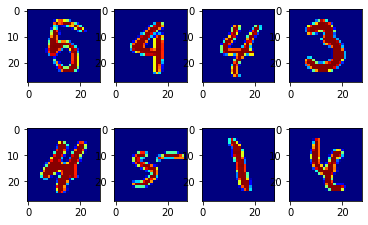

In [53]:
fig = plt.figure()
for idx, img in enumerate(simgs):
        plt.subplot(2,4,idx+1)
        plt.imshow(np.squeeze(img), cmap='jet', vmin=0, vmax=1)
plt.show()
plt.close()

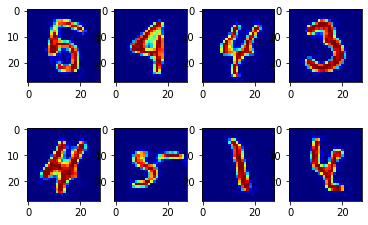

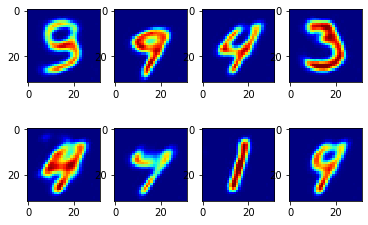

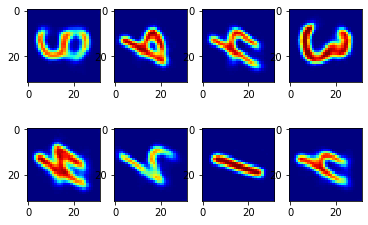

In [57]:
## visualize
for ikey in outputs.keys():
    fig = plt.figure()
    for idx, img in enumerate(outputs[ikey]):
        plt.subplot(2,4,idx+1)
        plt.imshow(np.squeeze(img), cmap='jet', vmin=0, vmax=1)
    plt.show()
    plt.close()

####  images for paper

In [59]:
# select image for test
index = np.where(y_test == 7)

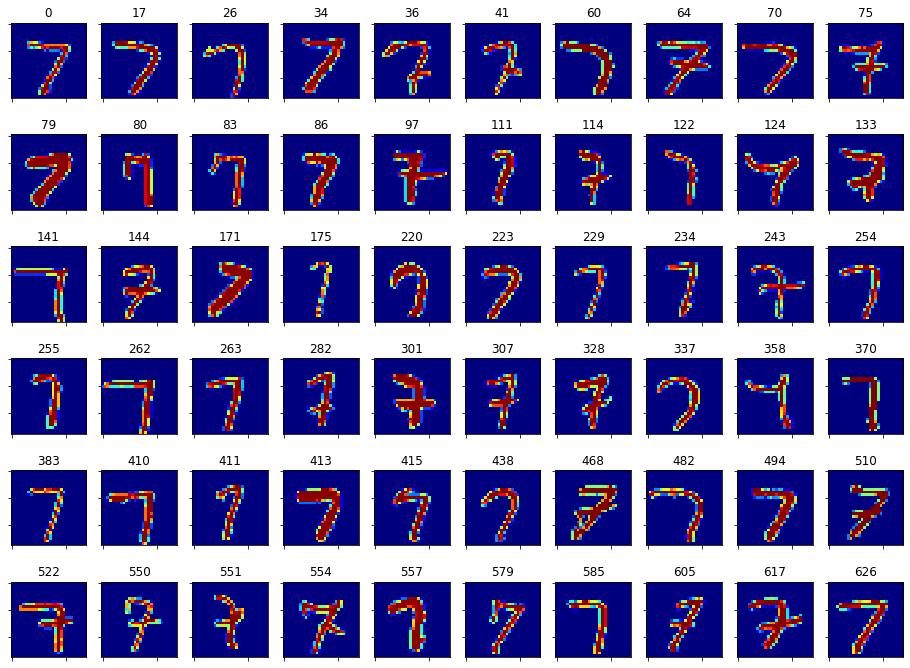

In [72]:
fig = plt.figure(figsize=(16,12))
for idx, i in enumerate(index[0][:60]):
    ax = plt.subplot(6,10,idx+1)
    ax.imshow(x_test[i]/255, cmap='jet', vmin=0, vmax=1)
    ax.set_title(i)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()

In [16]:
def rimgs_fn(x_test,index,h=32,w=32):
    simgs = x_test[index]/255
    simgs = simgs.astype(np.float32)
    rsimgs_tf = resize_image_fn(np.expand_dims(simgs,axis=-1), height=h, width=w) 
    
    rsimgs = tf.keras.backend.eval(rsimgs_tf)
    return rsimgs

In [17]:
def make_rotateImage(patches,index, copy_size=2, height=32, width=32,channel=1, random_angles=None):
    ## make rotate images
    h=w=28
    spatches = patches[index]/255
    img_list = []
    for patch in [spatches]:
        img_list.extend([np.reshape(patch, (1,h,w,channel))])
        img_list.extend([ np.expand_dims(np.copy(patch.reshape(h,w,channel)), axis=0) 
                     for i in range(copy_size-1)])
    imgs = np.concatenate(img_list, axis=0)
    print(imgs.shape)
    # rotate images
    radians = np.array(random_angles)*math.pi/180
    rimgs_tf = rotate_fn(imgs, angles=radians)
    rsize_imgs_tf = resize_image_fn(rimgs_tf, height=height, width=width)
    rtest_imgs = tf.keras.backend.eval(rsize_imgs_tf)
    return rtest_imgs

In [76]:
random_angles = np.random.randint(0,359,4)
random_angles

array([ 95, 323,  14, 266])

In [19]:
random_angles = np.array([ 95, 323,  14, 266])

In [20]:
rsimgs = make_rotateImage(x_test,index=17, copy_size=4, height=32, width=32,channel=1, random_angles=random_angles)
osimgs = make_rotateImage(x_test,index=17, copy_size=4, height=28, width=28,channel=1, random_angles=random_angles)

(4, 28, 28, 1)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

(4, 28, 28, 1)


In [21]:
rsimgs.shape, osimgs.shape

((4, 32, 32, 1), (4, 28, 28, 1))

In [41]:
## get restoration
outputs = {}
#for expname, inputs in zip(expnames, [osimgs, rsimgs, rsimgs]):
for expname, inputs in zip(expnames, [ rsimgs, rsimgs]):
    encs = encoder_dict[expname].predict(inputs)
    outputs[expname] = decoder_dict[expname].predict(encs)

In [33]:
def tplot_fn(imgs, simgs,rimgs,num_test_images,sindex, alpha=255, figsize=None,
             pfontsize=30,xloc=0.1,yys=None,dpi=None,savedir=None, savename=None, 
             label_on=False, labels=None, yfontsize=20): 
    f,a=plt.subplots(3,num_test_images,figsize=figsize,dpi=dpi)
    for idx, i in enumerate(range(num_test_images)):
        a[0][idx].imshow(np.squeeze(imgs[sindex]/alpha),  cmap='jet', vmin=0, vmax=1)
        a[1][idx].imshow(np.squeeze(simgs[idx]), cmap='jet', vmin=0, vmax=1)
        a[2][idx].imshow(np.squeeze(rimgs[idx]), cmap='jet', vmin=0, vmax=1)
        for ii in range(3):
            a[ii][idx].axes.get_xaxis().set_visible(False)
            a[ii][idx].axes.get_yaxis().set_visible(False)
        #if idx == 0:
        #    #yys = np.linspace(0.2,0.8,3)
        #    for ii in range(3):
        #        a[ii][idx].annotate(r"$\{$",fontsize=pfontsize,
        #            xy=(xloc,yys[ii]), xycoords='figure fraction',
        #            c= color
        #            )
    f.tight_layout()
    os.makedirs(savedir, exist_ok=True)
    pdf = PdfPages(os.path.join(savedir, savename))
    plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
    plt.show()
    pdf.close()
    pdf = None

In [ ]:
tplot_fn(imgs=x_test, simgs=osimgs,rimgs=outputs['original3'],num_test_images=4,sindex=17, figsize=(16,12),dpi=200,
        xloc=0.03, pfontsize=80, yys=np.linspace(0.12, 0.76,3),savedir='./figs', savename='mnist_L2_7.pdf',
        label_on=True,labels=['Original', 'Inputs', 'Restoration'], yfontsize=30)

In [ ]:
tplot_fn(imgs=x_test, simgs=osimgs,rimgs=outputs['62540480'],num_test_images=4,sindex=17, figsize=(16,12),dpi=200,
        xloc=0.03, pfontsize=80, yys=np.linspace(0.12, 0.76,3),savedir='./figs', savename='mnist_clf_7.pdf' )

In [ ]:
tplot_fn(imgs=x_test, simgs=osimgs,rimgs=outputs['66021965'],num_test_images=4,sindex=17, figsize=(16,12),dpi=200,
        xloc=0.03, pfontsize=80, yys=np.linspace(0.12, 0.76,3),savedir='./figs', savename='mnist_RI_7.pdf' )

In [ ]:
tplot_fn(imgs=x_test, simgs=osimgs,rimgs=outputs['8075852'],num_test_images=4,sindex=17, figsize=(16,12),dpi=200,
        xloc=0.03, pfontsize=80, yys=np.linspace(0.12, 0.76,3),savedir='./figs', savename='mnist_NRI_7.pdf' )

--------------------------
### t-SNE visualization
For RI model, we need to compute which layer become rotate invariant

In [204]:
def comp_tsne(imgs):
    n,h,w,c = imgs.shape
    embedded = TSNE(n_components=2).fit_transform(imgs.reshape(n,h*w*c))
    return embedded

In [199]:
simgs = np.expand_dims(x_test,axis=-1)/255
simgs = simgs.astype(np.float32)
h = w = 32
rsimgs_tf = resize_image_fn(simgs, height=h, width=w) 
rsimgs = tf.keras.backend.eval(rsimgs_tf)

In [200]:
# load encoder and decoder
encs_dict = {}
for expname, inputs in zip(expnames, [simgs, rsimgs, rsimgs]):
    encs = encoder_dict[expname].predict(inputs)
    encs_dict[expname] = encs

In [203]:
expnames, encs_dict['original3'].shape

(['original3', '62540480', '66021965'], (10000, 7, 7, 10))

#### compute t-SNE

In [436]:
import gc
gc.collect()

61899

In [437]:
ndata = 8000

In [438]:
tsne_L2 = comp_tsne(encs_dict['original3'][:ndata])

In [439]:
tsne_CLF = comp_tsne(encs_dict['62540480'][:ndata])

- test_RI: compute invariance layer for tSNE 

In [221]:
def copy_rot_fn(patches, height=None, width=None, ch=None, copy_size=None):
    img_list = []
    for patch in patches:
        img_list.extend([np.reshape(patch, (1,height,width,ch))])
        img_list.extend([ np.expand_dims(np.copy(patch.reshape(height,width,ch)), axis=0) 
                     for i in range(copy_size-1)])
    imgs = np.concatenate(img_list, axis=0)
    print(imgs.shape)
    
    radians = []
    for j in range(patches.shape[0]):
        radians.extend([i*math.pi/180 for i in np.linspace(0,360,copy_size+1) ][:-1] )
    print(len(radians))
    rimgs_tf = rotate_fn(imgs, angles=radians)
    rtest_imgs = tf.keras.backend.eval(rimgs_tf)
    del imgs, rimgs_tf
    return rtest_imgs

In [212]:
def comp_dec_result(encs, decoder, ): 
    decoder_results = {}
    model = decoder
    ### processing ###
    layer_names = [layer.name for layer in model.layers]
    for layer_name in layer_names[1:]:
        if 're_lu' in layer_name:
            tmp = Model(inputs=model.input, outputs=model.get_layer(layer_name).output) 
            decoder_results[layer_name] = tmp.predict(encs)
    return decoder_results

Compute layer information 

In [224]:
#
npatches=100

## get image for inferences
simgs = x_test[:npatches]/255
simgs = simgs.astype(np.float32)
h = w = 32
rsimgs_tf = resize_image_fn(np.expand_dims(simgs,axis=-1), height=h, width=w) 
rsimgs = tf.keras.backend.eval(rsimgs_tf)

## get encs
spatches = copy_rot_fn(rsimgs, height=32, width=32, ch=1, copy_size=12)
encs = encoder_dict['66021965'].predict(spatches)

ri_decoder_results = comp_dec_result(encs=encs, decoder=decoder_dict['66021965'] )

(1200, 32, 32, 1)
1200


In [225]:
ri_decoder_results.keys()

dict_keys(['leaky_re_lu_15', 'leaky_re_lu_16', 'leaky_re_lu_17', 'leaky_re_lu_18', 'leaky_re_lu_19', 'leaky_re_lu_20', 'leaky_re_lu_21', 'leaky_re_lu_22', 'leaky_re_lu_23', 'leaky_re_lu_24', 'leaky_re_lu_25', 'leaky_re_lu_26', 'leaky_re_lu_27', 'leaky_re_lu_28', 'leaky_re_lu_29', 'leaky_re_lu_30'])

In [226]:
ri_decoder_results['leaky_re_lu_15'].shape

(1200, 2, 2, 128)

In [227]:
### save name
savedir = './pkl'
os.makedirs(savedir, exist_ok=True)
with open(os.path.join(savedir, f'ri_decoder_results_{npatches}.pkl'), 'wb') as handle:
    pickle.dump(ri_decoder_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Import computed file and decide layer: **Compute average over degree for each layer**

In [228]:
filename = os.path.join('./pkl', 'result_ri_decoder_results_100.pkl')
with open(filename, 'rb') as handle:
    decoder_cos_results = pickle.load(handle)

In [229]:
def comp_means(results, ikey=None):
    result = results[ikey] # (npatches, ncopues)
    deg_mean = np.mean(result, axis=0)
    return deg_mean

In [236]:
deg_mean_list = {}
for ikey in decoder_cos_results.keys():
    deg_mean_list[ikey] =  comp_means(decoder_cos_results, ikey=ikey)

In [246]:
# compute average overall patches
deg_means = []
for ikey in deg_mean_list.keys():
    deg_means.append(np.mean(deg_mean_list[ikey]))
deg_mean_df = pd.DataFrame(deg_means)
deg_mean_df.columns = ['cosine sim']
deg_mean_df.index = [ikey for ikey in decoder_cos_results.keys()]

In [247]:
deg_mean_df

,cosine sim
leaky_re_lu_15,0.846700
leaky_re_lu_16,0.950585
leaky_re_lu_17,0.989604
leaky_re_lu_18,0.996654
leaky_re_lu_19,0.997921
leaky_re_lu_20,0.998269
leaky_re_lu_21,0.998544
leaky_re_lu_22,0.998444
leaky_re_lu_23,0.998317
leaky_re_lu_24,0.998234


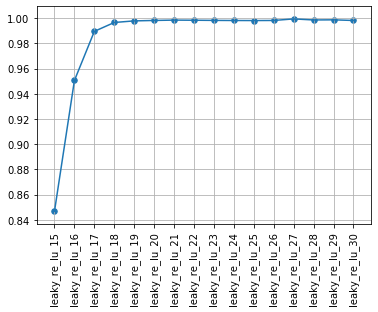

In [254]:
plt.figure()
plt.plot(deg_mean_df['cosine sim'])
plt.scatter([i for i in range(len(deg_mean_df))],
            deg_mean_df['cosine sim'], s=30)
plt.xticks([ikey for ikey in decoder_cos_results.keys()], rotation='vertical')
plt.grid(True)
plt.show()

#### Memo: 'leaky_re_lu_17'

In [440]:
# 
encs = encs_dict['66021965'][:ndata]
layer_name = 'leaky_re_lu_17'
model = decoder_dict['66021965']
#
tmp = Model(inputs=model.input, outputs=model.get_layer(layer_name).output) 
decs= tmp.predict(encs[:ndata])
tsne_RI = comp_tsne(decs)

In [441]:
tsne_RI.shape

(8000, 2)

##### Visualize tSNE

In [272]:
colors = get_rand_colors(10, cmap_name='tab10')

In [273]:
colors

['#2ca02c',
 '#e377c2',
 '#1f77b4',
 '#8c564b',
 '#d62728',
 '#ff7f0e',
 '#17becf',
 '#7f7f7f',
 '#9467bd',
 '#bcbd22']

In [423]:
def tsplot_fn(embedded, y_test, nclass=10, figsize=(8,6), dpi=100,colors=None,cmap=None, 
              images=None,linewidth=None, zoom=1.25, s1=20, s2=10, savedir=None, savename=None, ploc=0):
    
    def add_image(img, xy,color,linewidth):
        imagebox = OffsetImage(img, zoom)
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, xy,
                        xycoords='data',
                        boxcoords="offset points",
                        pad=0.,
                        bboxprops =dict(edgecolor=color,linewidth=linewidth,)
                        )
        return ab
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.scatter(embedded[:, 0], embedded[:,1], color='grey', s=s1)
    ax = plt.subplot(1,1,1)
    
    # change default mlp color
    plt.rcParams['image.cmap'] = cmap
    
    for i in range(nclass):
        idx = np.argwhere(y_test == i)
        ax.scatter(embedded[idx, 0], embedded[idx,1], color=colors[i], s=s2)

        #ax.axes.get_xaxis().set_visible(False)
        #ax.axes.get_yaxis().set_visible(False)
        
        xy = (embedded[idx[ploc[i]], 0][0], embedded[idx[ploc[i]],1][0])
        #print(xy)
        ab  = add_image(images[i], xy,colors[i],linewidth)
        ax.add_artist(ab)
    ax.axis('off')
    # save
    #plt.show()
    os.makedirs(savedir, exist_ok=True)
    pdf = PdfPages(os.path.join(savedir, savename))
    plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
    plt.show()
    pdf.close()
    pdf = None

In [375]:
images = []
for i in range(10):
    if i != 5:
        idx = np.where(y_test == i)[0][0]
    if i == 5:
        idx = np.where(y_test == i)[0][1]
    images.append(Image.fromarray(np.uint8(x_test[idx]), 'L' ).convert('L'))  

In [ ]:
tsplot_fn(tsne_L2, y_test[:ndata], figsize=(14,12),colors=colors, cmap='gist_gray', images=images, linewidth=10,
         s1=40,s2=30,zoom=1.75, savedir='./figs', savename='tsne-mnist-L2.pdf',
          ploc=[0,0,0,0,0,2,1,0,0,300])

In [ ]:
tsplot_fn(tsne_CLF, y_test[:ndata], figsize=(14,12),colors=colors, cmap='gist_gray', images=images, linewidth=10,
         s1=40,s2=30,zoom=1.75, savedir='./figs', savename='tsne-mnist-CLF.pdf', 
        ploc=[0,1,0,1,1,2,0,0,0,0,0])

In [ ]:
tsplot_fn(tsne_RI, y_test[:ndata], figsize=(14,12),colors=colors, cmap='gist_gray', images=images, linewidth=10,
         s1=40,s2=30,zoom=1.75, savedir='./figs', savename='tsne-mnist-RI.pdf', 
        ploc=[0,0,0,1,1,2,0,0,0,0,0])

------------------------
## 3. Visualize Training Loss

### 3.1 CLF autoencoder

In [5]:
def get_loss(logdir, log_fname, param):
    # check ltrain-reconst-oss curve
    fname =  os.path.join(logdir, logname)  #'./log/'+log_fname
    loss_list = []
    with open(fname,'r') as f:
        lines = f.readlines()
        for line in lines:
            tmps = []
            for iline in line.split('\n'):
                for _line in iline.split(','):
                    if len(_line) > 0:
                        tmps.append(float(_line))
            loss_list.append(np.array(tmps))
    
    n = len(loss_list)
    loss_array = np.zeros((n,2))
    loss_array = loss_array.astype(float)
    for idx, i in enumerate(loss_list):
        #print(i, len(i))
        for jdx, j in enumerate(i):
            if jdx == 0:
                loss_array[idx, jdx] = j
            else:
                loss_array[idx, jdx] = j/param
    return loss_array

##### list of expname
   - "62610249": 10
   - "62522279",: 1
   - "62538901",:0.1
   - "62920647":0.01

In [4]:
logdir = "/project2/foster/clouds/metrics_20200208/metrics/log"

In [6]:
expnames = [
    "62610249",
    "62522279",
    "62538901",
    "62920647"
]

In [7]:
lognames = [
    "loss_62610249_nepoch-25_lr-0.01_nbatch-32_lambda10.0_dangle11569079639.txt",
    "loss_62522279_nepoch-25_lr-0.01_nbatch-32_lambda1.0_dangle11568750264.txt",
    "loss_62538901_nepoch-25_lr-0.01_nbatch-32_lambda0.1_dangle11568838221.txt",
    "loss_62920647_nepoch-50_lr-0.01_nbatch-32_lambda0.01_dangle11570470738.txt",
]

In [8]:
params = [10,1,0.1,0.01]

Get log file

In [9]:
loss_dict = {}
for expname, logname, param in zip(expnames, lognames, params):
    loss_array = get_loss(logdir, logname,param )
    loss_dict[f'{param}'] = loss_array

In [10]:
loss_dict.keys()

dict_keys(['10', '1', '0.1', '0.01'])

Get log file for extending training result

In [11]:
loss_dict2 = {}
logname = "loss_62540480_nepoch-25_lr-0.01_nbatch-32_lambda0.1_dangle11568844481.txt"
loss_dict2['62540480'] = get_loss(logdir, logname,0.1 )

###### Update: "62538901"+'62540480'

In [12]:
a = loss_dict["0.1"] 
b = loss_dict2['62540480']
new_loss_list = []
for i in [a,b]:
    new_loss_list.append(i)
tmp = np.concatenate(new_loss_list,axis=0)
tmp.shape

(3450, 2)

In [13]:
# update here!
loss_dict["0.1"] = tmp

###### ploto here!

In [14]:
savedir='./figs'
savename='loss_clf_mnist.pdf'

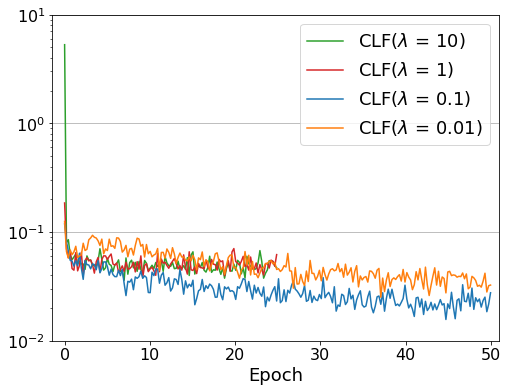

In [17]:
plt.figure(figsize=(8,6))
plt.rcParams["font.size"] = 16
cs = ["C2", "C3",'C0','C1',  "C4", "C5"]

for idx, ikey in enumerate(loss_dict.keys()):
    array = loss_dict[str(ikey)]
    x = np.array([ i for i in range(0,len(array),15)])
    all_array = array[:,0] + array[:, 1]
    #plt.plot(x,all_array[x], linewidth=1.5, color=cs[idx])
    #plt.scatter(x,all_array[x], s=18, label=r'CLF($\lambda$ = '+str(params[idx])+')',color=cs[idx])
    plt.plot(x,all_array[x], linewidth=1.5, color=cs[idx], label=r'CLF($\lambda$ = '+str(params[idx])+')',)
    


plt.gca().yaxis.grid(True)
plt.xlabel('Epoch', fontsize=18)
#plt.ylabel('Training Loss')
plt.xticks( [i*0.01 for i in range(0,345001, 6875*10)], [i for i in range(0,51,10)] )
plt.xlim(-100,3500)
#plt.ylim(0,0.2)
#plt.yticks(np.linspace(0,0.2,6))
plt.ylim(0.01,10.)
plt.yscale('log')
plt.legend(ncol=1, fontsize=18)
#plt.show()

# save
os.makedirs(savedir, exist_ok=True)
pdf = PdfPages(os.path.join(savedir, savename))
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()

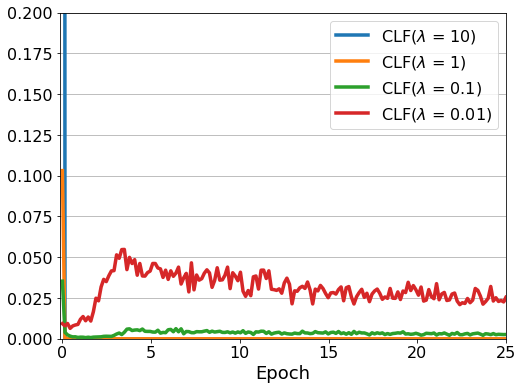

In [71]:
plt.figure(figsize=(8,6))
plt.rcParams["font.size"] = 16
cs = ['C0','C1', "C2", "C3", "C4", "C5"]

for idx, ikey in enumerate(loss_dict.keys()):
    array = loss_dict[str(ikey)]
    x = np.array([ i for i in range(0,len(array),10)])
    all_array =  array[:, 1]
    #plt.plot(x,all_array[x], linewidth=1.5, color=cs[idx])
    #plt.scatter(x,all_array[x], s=18, label=r'CLF($\lambda$ = '+str(params[idx])+')',color=cs[idx])
    plt.plot(x,all_array[x], linewidth=3.5, color=cs[idx], label=r'CLF($\lambda$ = '+str(params[idx])+')',)
    


plt.gca().yaxis.grid(True)
plt.xlabel('Epoch', fontsize=18)
#plt.ylabel('Training Loss')
plt.xticks( [i*0.01 for i in range(0,175001, 6875*5)], [i for i in range(0,26,5)] )
plt.xlim(-10,1720)
plt.ylim(0,0.2)
plt.legend(ncol=1, fontsize=16)
plt.show()

### 3.2 RI autoenoder 
Table of lossname = inv:res  
- 0.1:0.1; "6938961"
- 0.1:1; "65976888","66030529", 
- 0.1:10; "6938960"
- 1.0:0.1: "65973248_66046429" (65945097,65966109,66046429, "65973248_66046429")
- 1.0:1.0 "65939726" + "65952364" ("66046822")
- 1.0:10 " "65946103", "65953273"(65946103, 65953273)
- 10:0.1; "6938956"
- 10:1.0; "65966218","66030707" 
- 10:10; "6938958"

In [18]:
def get_loss(logdir, log_fnames, ncol=3):
    for idx, _logfname in enumerate(log_fnames):
        logfname = os.path.basename(_logfname)
        if idx == 0:
            loss_array = _get_loss(logdir, logfname, ncol)
        else:
            tmp_array = _get_loss(logdir, logfname, ncol)
            loss_array = np.concatenate([loss_array, tmp_array], axis=0)

    return loss_array

def _get_loss(logdir, log_fname, ncol=3):
    # check ltrain-reconst-oss curve
    fname =  os.path.join(logdir, log_fname)  #'./log/'+log_fname
    loss_list = []
    with open(fname,'r') as f:
        lines = f.readlines()
        for line in lines:
            tmps = []
            for iline in line.split('\n'):
                for _line in iline.split(','):
                    if len(_line) > 0:
                        tmps.append(float(_line))
            loss_list.append(np.array(tmps))
    
    n = len(loss_list)
    loss_array = np.zeros((n,ncol))
    loss_array = loss_array.astype(float)
    for idx, i in enumerate(loss_list):
        #print(i, len(i))
        for jdx, j in enumerate(i):
            #if jdx == 0:
            #    loss_array[idx, jdx] = j
            #else:
            loss_array[idx, jdx] = j
    return loss_array

In [19]:
logdir="/home/tkurihana/rotate_invariant/stepbystep/transform/log"

In [20]:
# inv-res
param_dict = {
    "0.1-0.1":["6938961"],
    "0.1-1": ["65976888","66030529"],
    "0.1-10": ["6938960"],
    "1-0.1": ["65973248", "66046429"],
    "1-1": ["65939726","65952364"],
    "1-10": ["65946103","65953273"],
    "10-0.1": ["6938956"],
    "10-1": ["65966218","66030707"],
    "10-10": ["6938958"]
}

In [21]:
params = [0.1,1,10]
loss_dict = {}
for inv in params:
    for res in params:
        print(inv, res)
        keybase_list = param_dict[f"{inv}-{res}"] 
        logfnames = []
        for i in keybase_list:
            keybase=f"*{i}*.txt"
            logfnames.extend(glob.glob(os.path.join(logdir, keybase)))
        #print(logfnames)
        #print("length === ",len(logfnames))
        print(logfnames)
        loss_dict[f"{inv}-{res}"] = get_loss(logdir, logfnames, ncol=3)

0.1 0.1
['/home/tkurihana/rotate_invariant/stepbystep/transform/log/loss_6938961_nepoch-50_lr-0.01_nbatch-16_lambda0.11605597915.txt']
0.1 1
['/home/tkurihana/rotate_invariant/stepbystep/transform/log/loss_65976888_nepoch-20_lr-0.01_nbatch-32_lambda1.01582337570.txt', '/home/tkurihana/rotate_invariant/stepbystep/transform/log/loss_66030529_nepoch-80_lr-0.01_nbatch-32_lambda1.01582587042.txt']
0.1 10
['/home/tkurihana/rotate_invariant/stepbystep/transform/log/loss_6938960_nepoch-50_lr-0.01_nbatch-16_lambda10.01605596888.txt']
1 0.1
['/home/tkurihana/rotate_invariant/stepbystep/transform/log/loss_65973248_nepoch-20_lr-0.01_nbatch-32_lambda0.11582326285.txt', '/home/tkurihana/rotate_invariant/stepbystep/transform/log/loss_66046429_nepoch-80_lr-0.01_nbatch-32_lambda0.11582656675.txt']
1 1
['/home/tkurihana/rotate_invariant/stepbystep/transform/log/loss_65939726_nepoch-20_lr-0.01_nbatch-32_lambda1.01582227278.txt', '/home/tkurihana/rotate_invariant/stepbystep/transform/log/loss_65952364_nep

Visualize parameter search result

In [22]:
savedir='./figs'
savename='loss_ri_mnist.pdf'

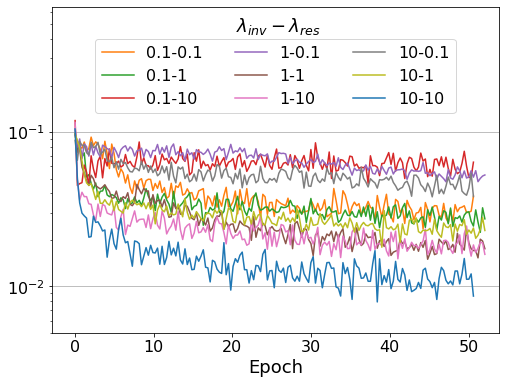

In [23]:
fig = plt.figure(figsize=(8,6))
plt.rcParams["font.size"] = 16
ax = plt.subplot(1,1,1)
cs = [f"C{i}" for i in range(1,9,1)]+['C0']
for ic, ikey in enumerate(loss_dict.keys()):
    x = np.arange(0, len(loss_dict[ikey]),1 )
    array = loss_dict[ikey]
    loss = array[:,0]+ array[:,1]
    idx = np.array([ i for i in range(0,len(array),10)])
    plt.plot(x[idx],loss[idx],label=ikey, color=cs[ic], linewidth=1.5,)
plt.yscale('log')
plt.xticks( [i*0.01 for i in range(0,175001, int(6875/2)*10)], [i for i in range(0,51,10)] )
plt.xlim(-100,1850)
plt.ylim(0.005, .65)
plt.gca().yaxis.grid(True)
plt.xlabel('Epoch', fontsize=18)
plt.legend(ncol=3, fontsize=16, loc='upper center',bbox_to_anchor=(0.5, 0.925))
ax.text(1950/2-270,0.45, r"$\lambda_{inv} - \lambda_{res}$", fontsize=18)
# save
os.makedirs(savedir, exist_ok=True)
pdf = PdfPages(os.path.join(savedir, savename))
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()

- visualization check

In [26]:
# dir
basedir = "/home/tkurihana/rotate_invariant/stepbystep/transform"
# load encoder and decoder
encoder_dict = {}
decoder_dict = {}
expnames = []
for inv in params:
    for res in params:
        keybase_list = param_dict[f"{inv}-{res}"] 
        expnames.append(keybase_list[-1])

edlist = [ i for i in encoder_dict.keys()]
print(expnames)
for expname in expnames:
    model_dir = os.path.join(basedir, 'output_model/'+expname)
    os.path.exists(model_dir)
    
    if not expname in edlist:
        encoder_dict[expname] = load_latest_model(model_dir, mtype='encoder')
        decoder_dict[expname] = load_latest_model(model_dir, mtype='decoder')

['6938961', '66030529', '6938960', '66046429', '65952364', '65953273', '6938956', '66030707', '6938958']
 Load encoder at 50 epoch
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
 Load decoder at 50 epoch
 Load encoder at 79 epoch
 Load decoder at 79 epoch
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
 Load encoder at 50 epoch
 Load decoder at 50 epoch
 Load encoder at 79 epoch
 Load decoder at 79 epoch
 Load encoder at 79 epoch
 Load decoder at 79 epoch
 Load encoder at 79 epoch
 Load decoder at 79 epoch
 Load encoder at 50 epoch
 Loa

##### Produce rsimgs by `make_rotateImage` function

In [30]:
def tplot_fn(imgs, simgs,rimgs,num_test_images,sindex, alpha=255, figsize=None,
             pfontsize=30,xloc=0.1,yys=None,dpi=None,savedir=None, savename=None, 
             label_on=False, labels=None, yfontsize=20): 
    f,a=plt.subplots(3,num_test_images,figsize=figsize,dpi=dpi)
    for idx, i in enumerate(range(num_test_images)):
        a[0][idx].imshow(np.squeeze(imgs[sindex]/alpha),  cmap='jet', vmin=0, vmax=1)
        a[1][idx].imshow(np.squeeze(simgs[idx]), cmap='jet', vmin=0, vmax=1)
        a[2][idx].imshow(np.squeeze(rimgs[idx]), cmap='jet', vmin=0, vmax=1)
        for ii in range(3):
            a[ii][idx].axes.get_xaxis().set_visible(False)
            a[ii][idx].axes.get_yaxis().set_visible(False)
    f.tight_layout()
    #os.makedirs(savedir, exist_ok=True)
    #pdf = PdfPages(os.path.join(savedir, savename))
    #plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
    plt.show()
    #plt.close()
    #pdf.close()
    #pdf = None

In [23]:
## get restoration
outputs = {}
for expname in expnames:
    encs = encoder_dict[expname].predict(rsimgs)
    outputs[expname] = decoder_dict[expname].predict(encs)

In [29]:
outputs.keys()

dict_keys(['6938961', '66030529', '6938960', '66046429', '65952364', '65953273', '6938956', '66030707', '6938958'])

In [24]:
outputs.keys()

dict_keys(['8075852'])

#### NRI for mnist

In [25]:
inv_param_dict = {
    "8075852":"NRI",
}


 ### 8075852 NRI ### 



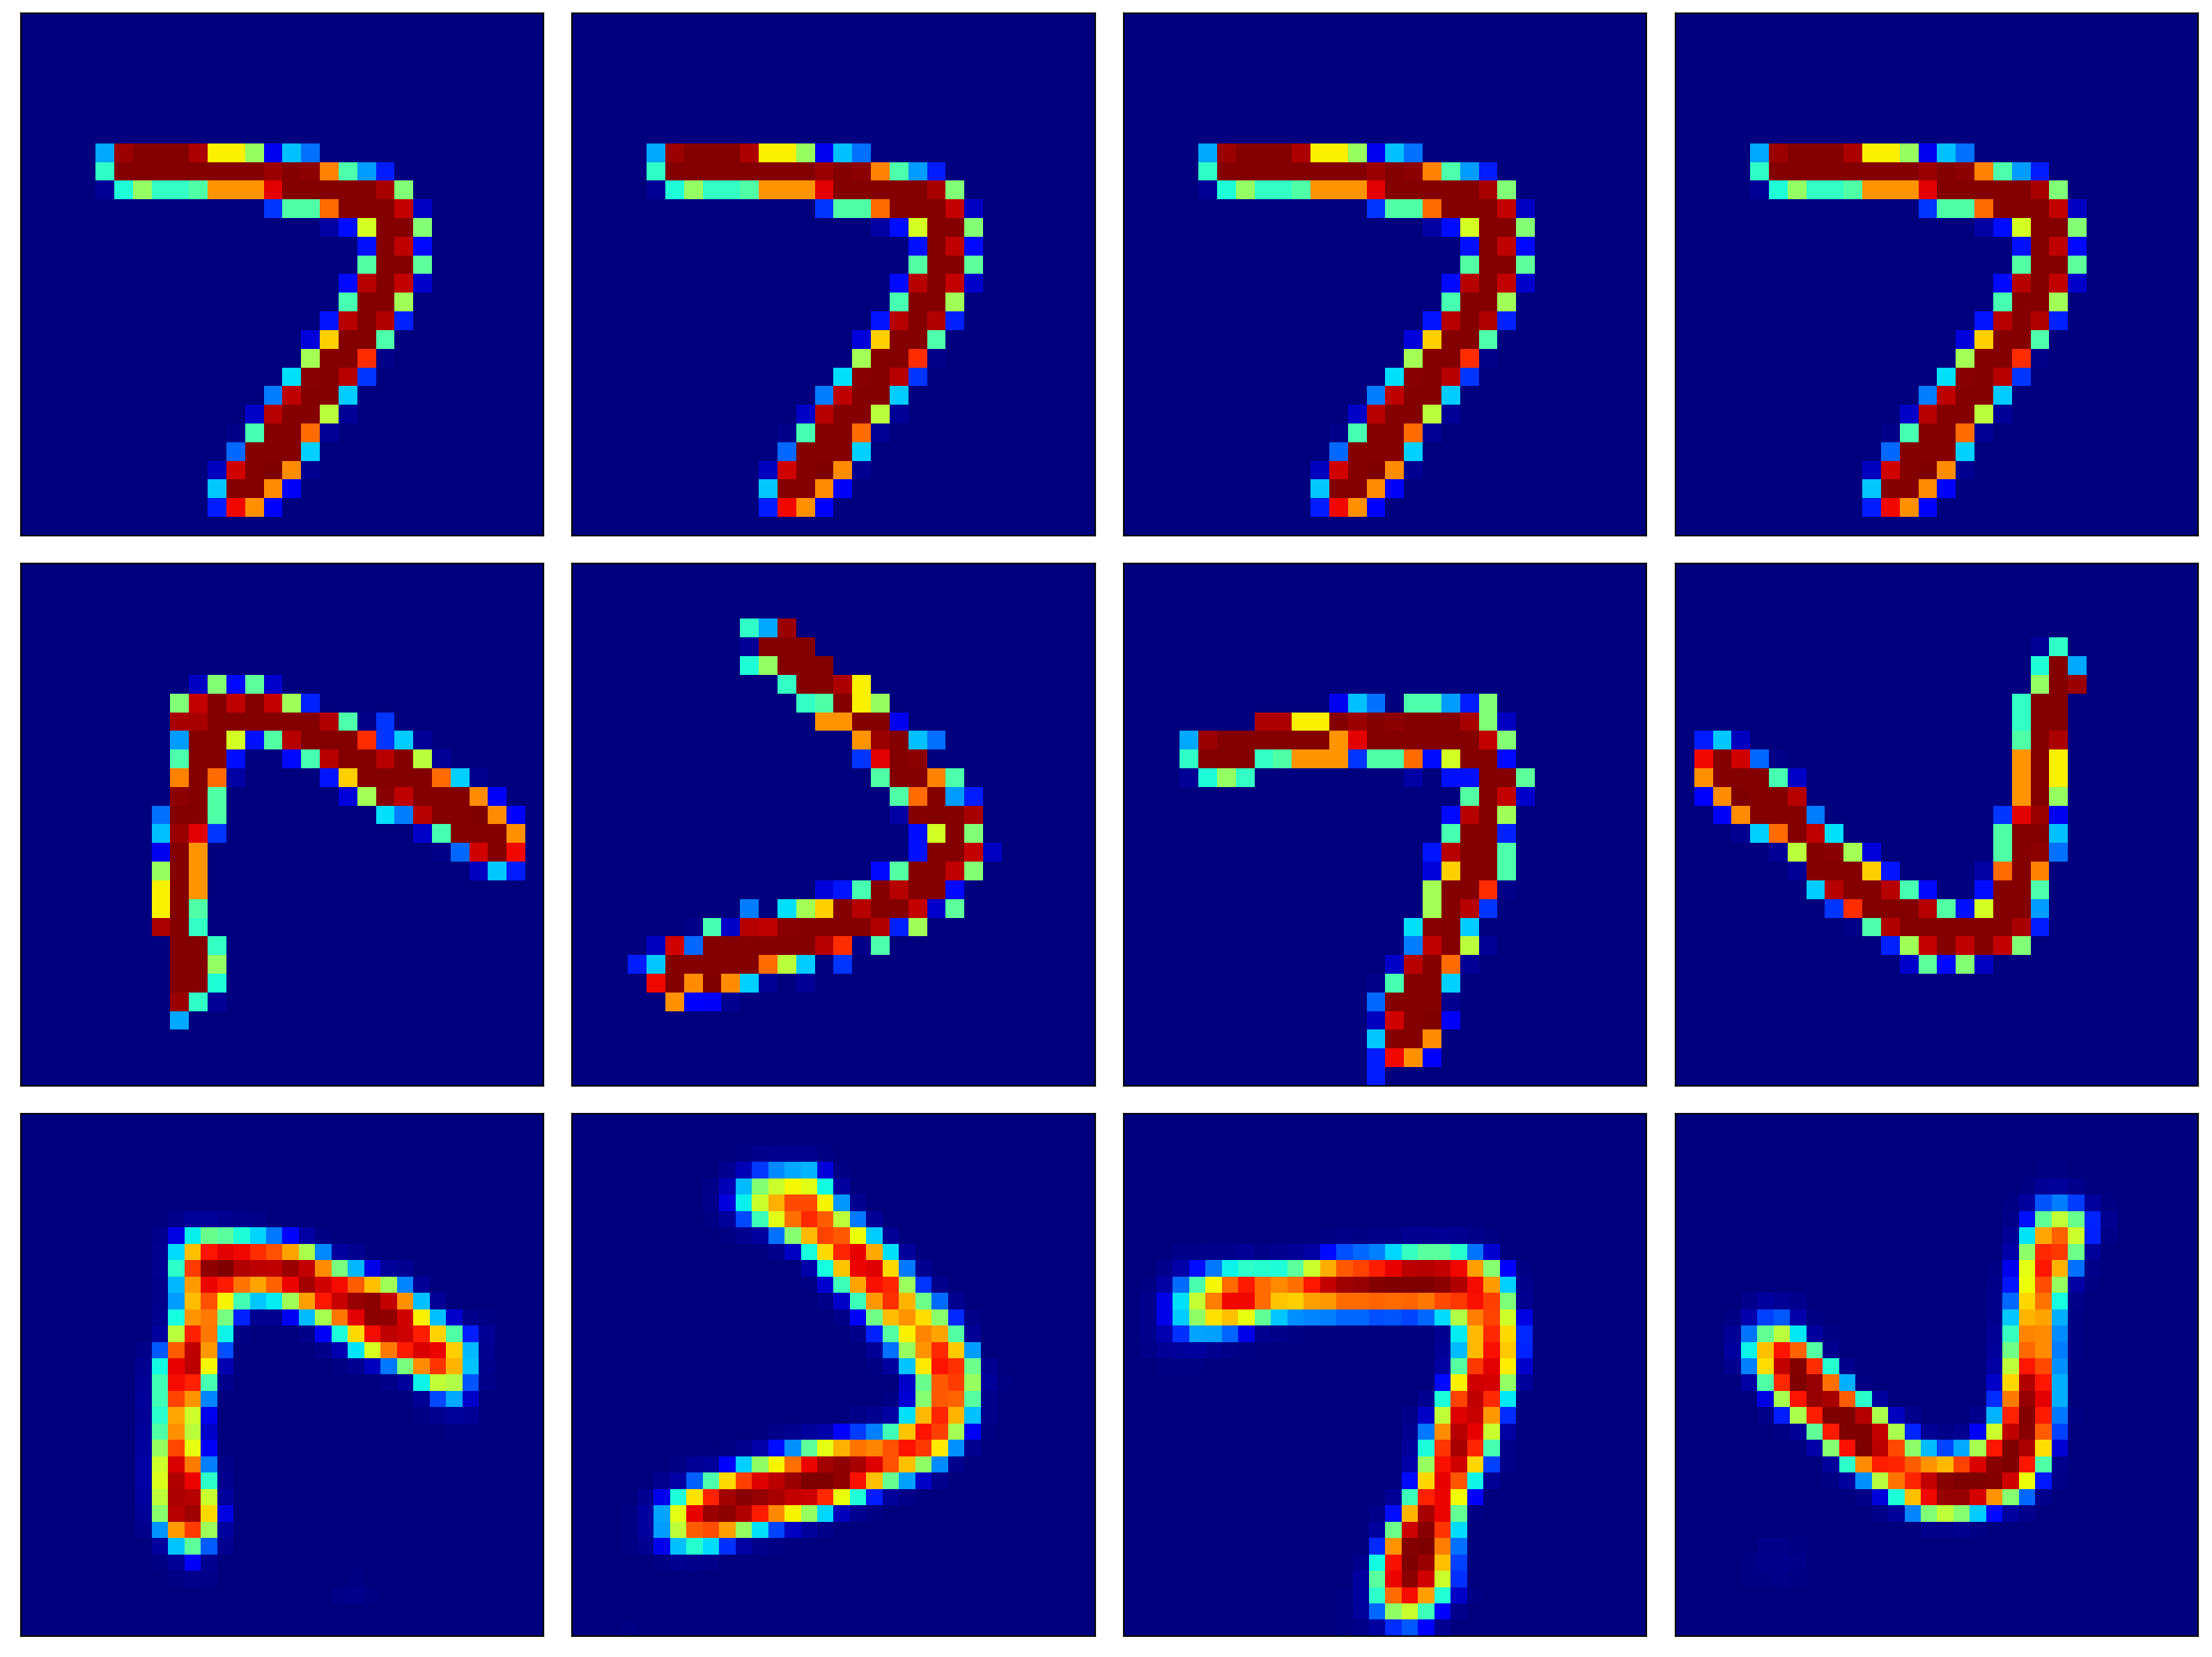

In [28]:
for i, ikey in enumerate(outputs.keys()):
    print(f"\n ### {ikey} {inv_param_dict[ikey]} ### \n")
    tplot_fn(imgs=x_test, simgs=osimgs,rimgs=outputs[ikey],num_test_images=4,
             sindex=17, figsize=(16,12),dpi=200,
             xloc=0.03, pfontsize=80, yys=np.linspace(0.12, 0.76,3),savedir='./figs', savename='xxx.pdf',
             label_on=True,labels=['Original', 'Inputs', 'Restoration'], yfontsize=30)

#### L2, RA and RI

In [30]:
inv_param_dict = {
    "6938961":"0.1-0.1",
    "66030529":"0.1-1",
    "6938960": "0.1-10",
    "66046429": "1-0.1",
    "65952364":"1-1",
    "65953273":"1-10",
    "6938956":"10-0.1",
    "66030707": "10-1",
    "6938958":"10-10",
}


 ### 6938961 0.1-0.1 ### 



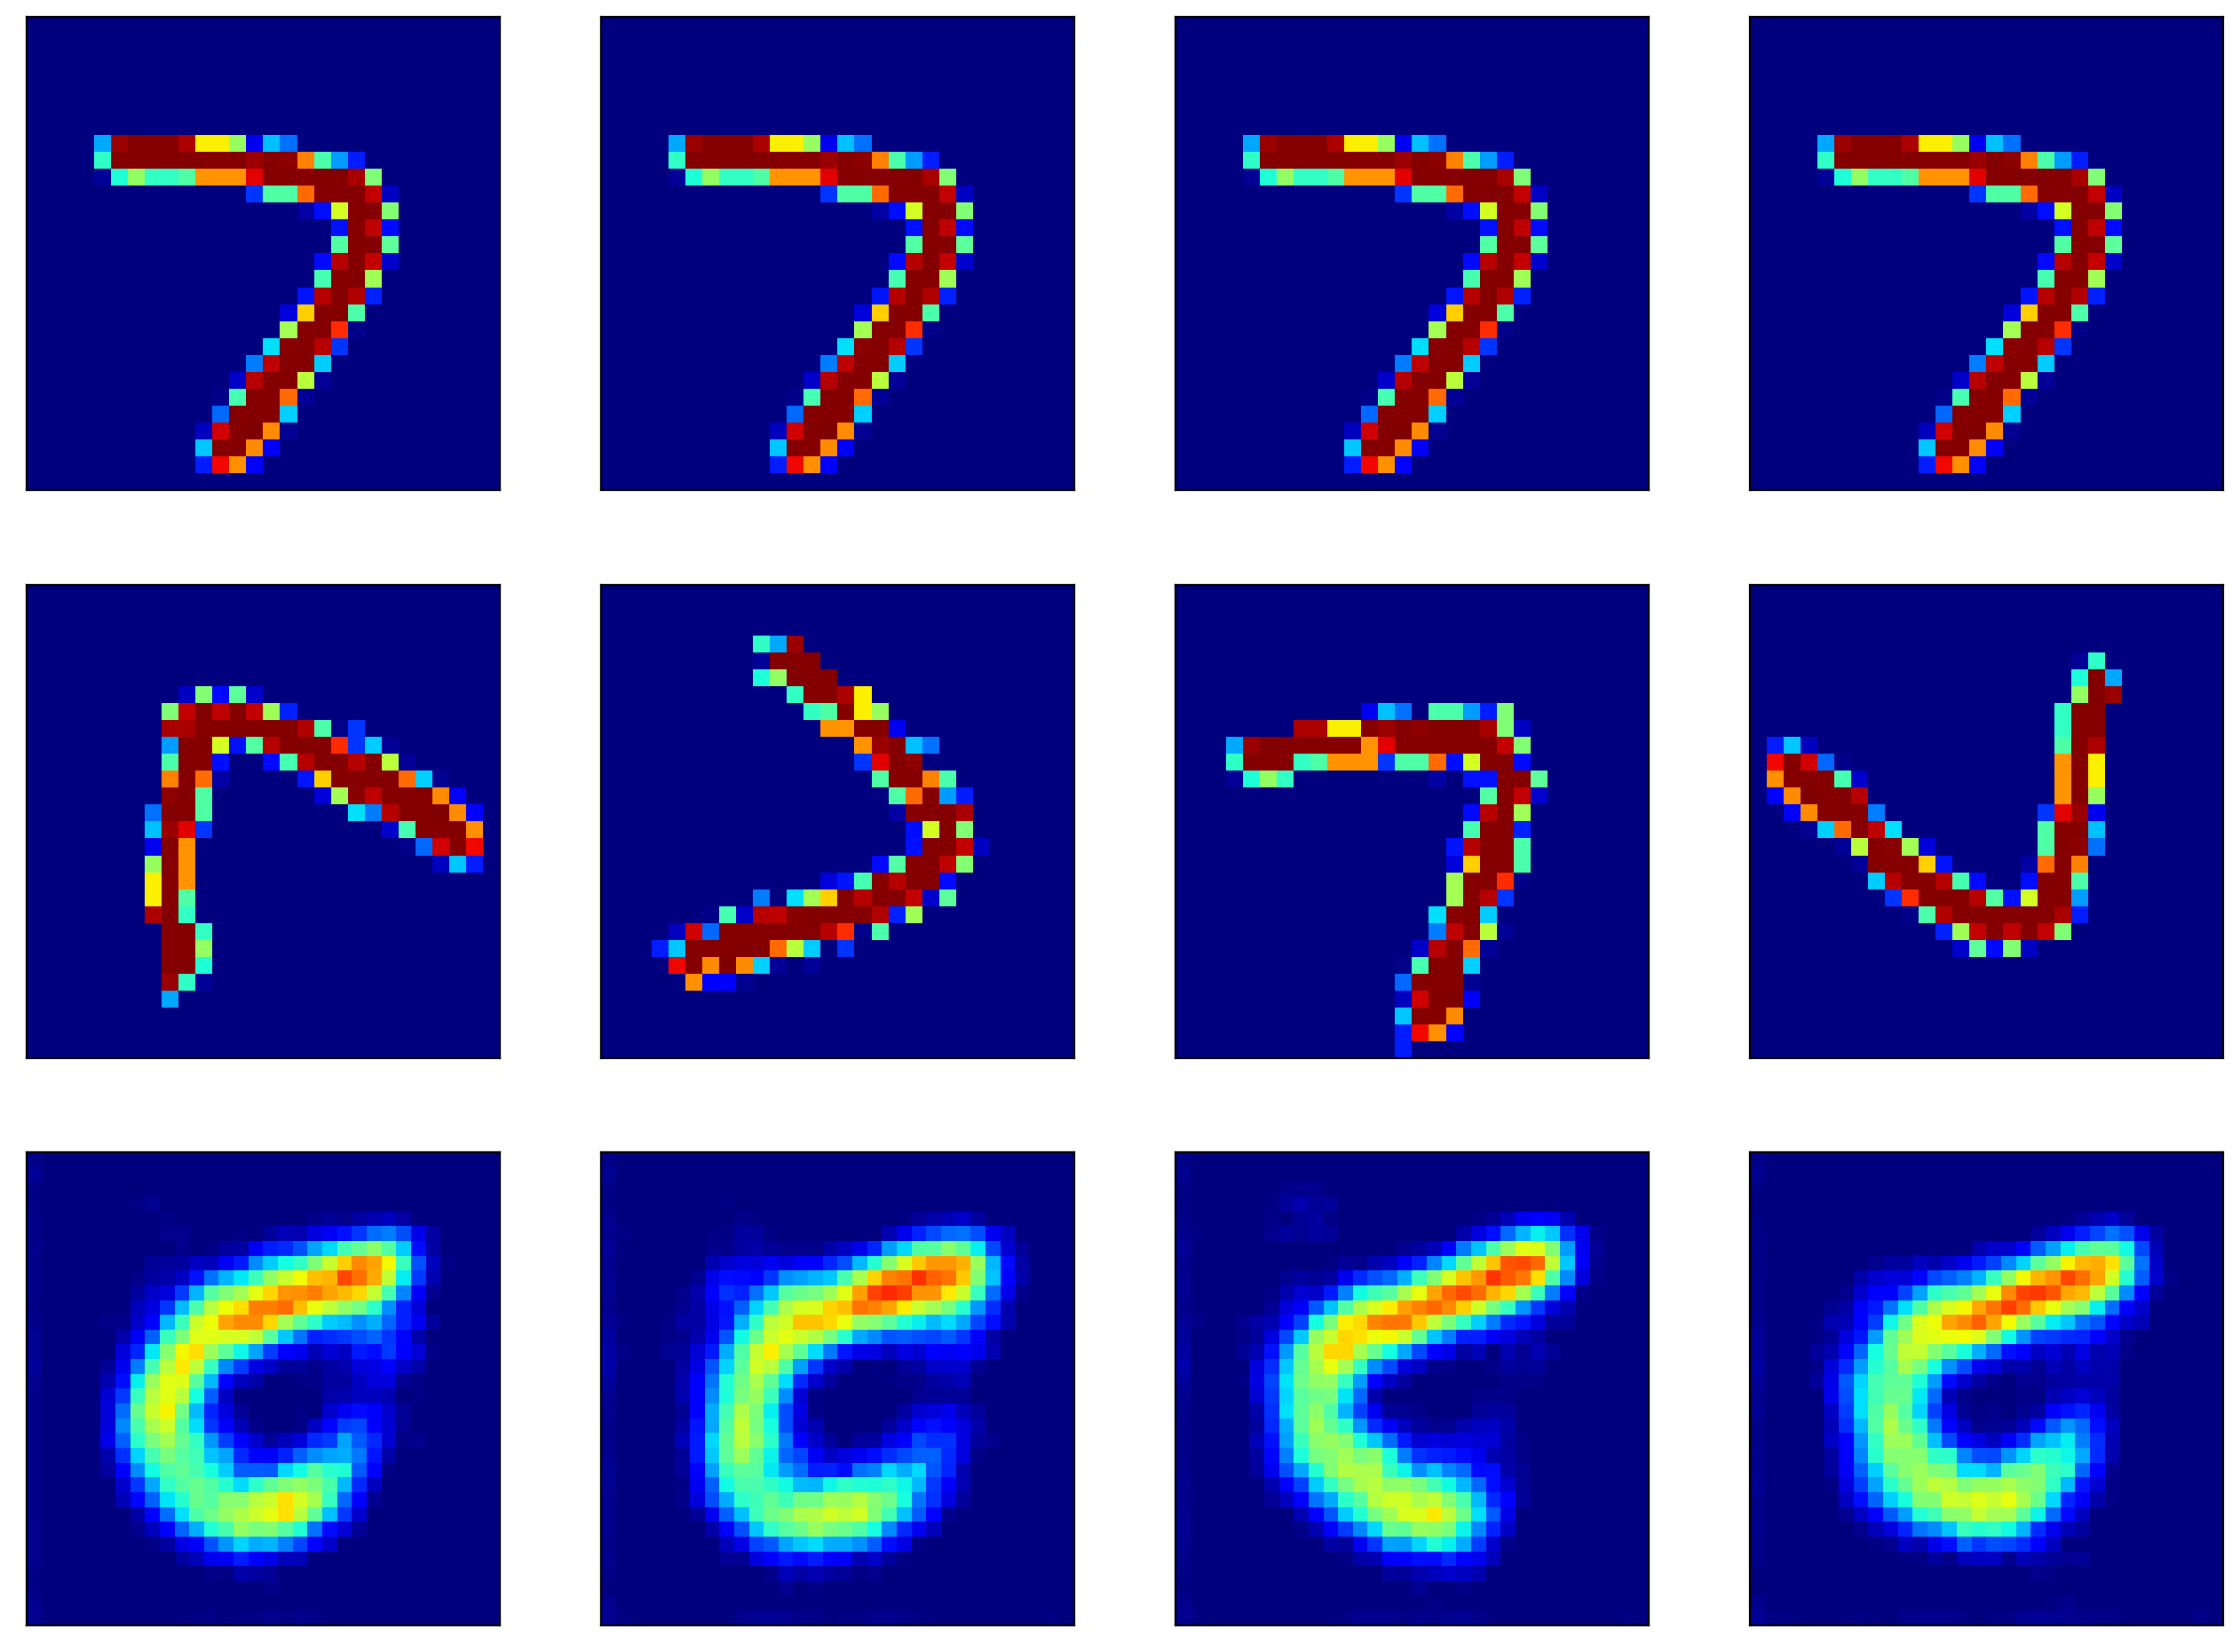


 ### 66030529 0.1-1 ### 



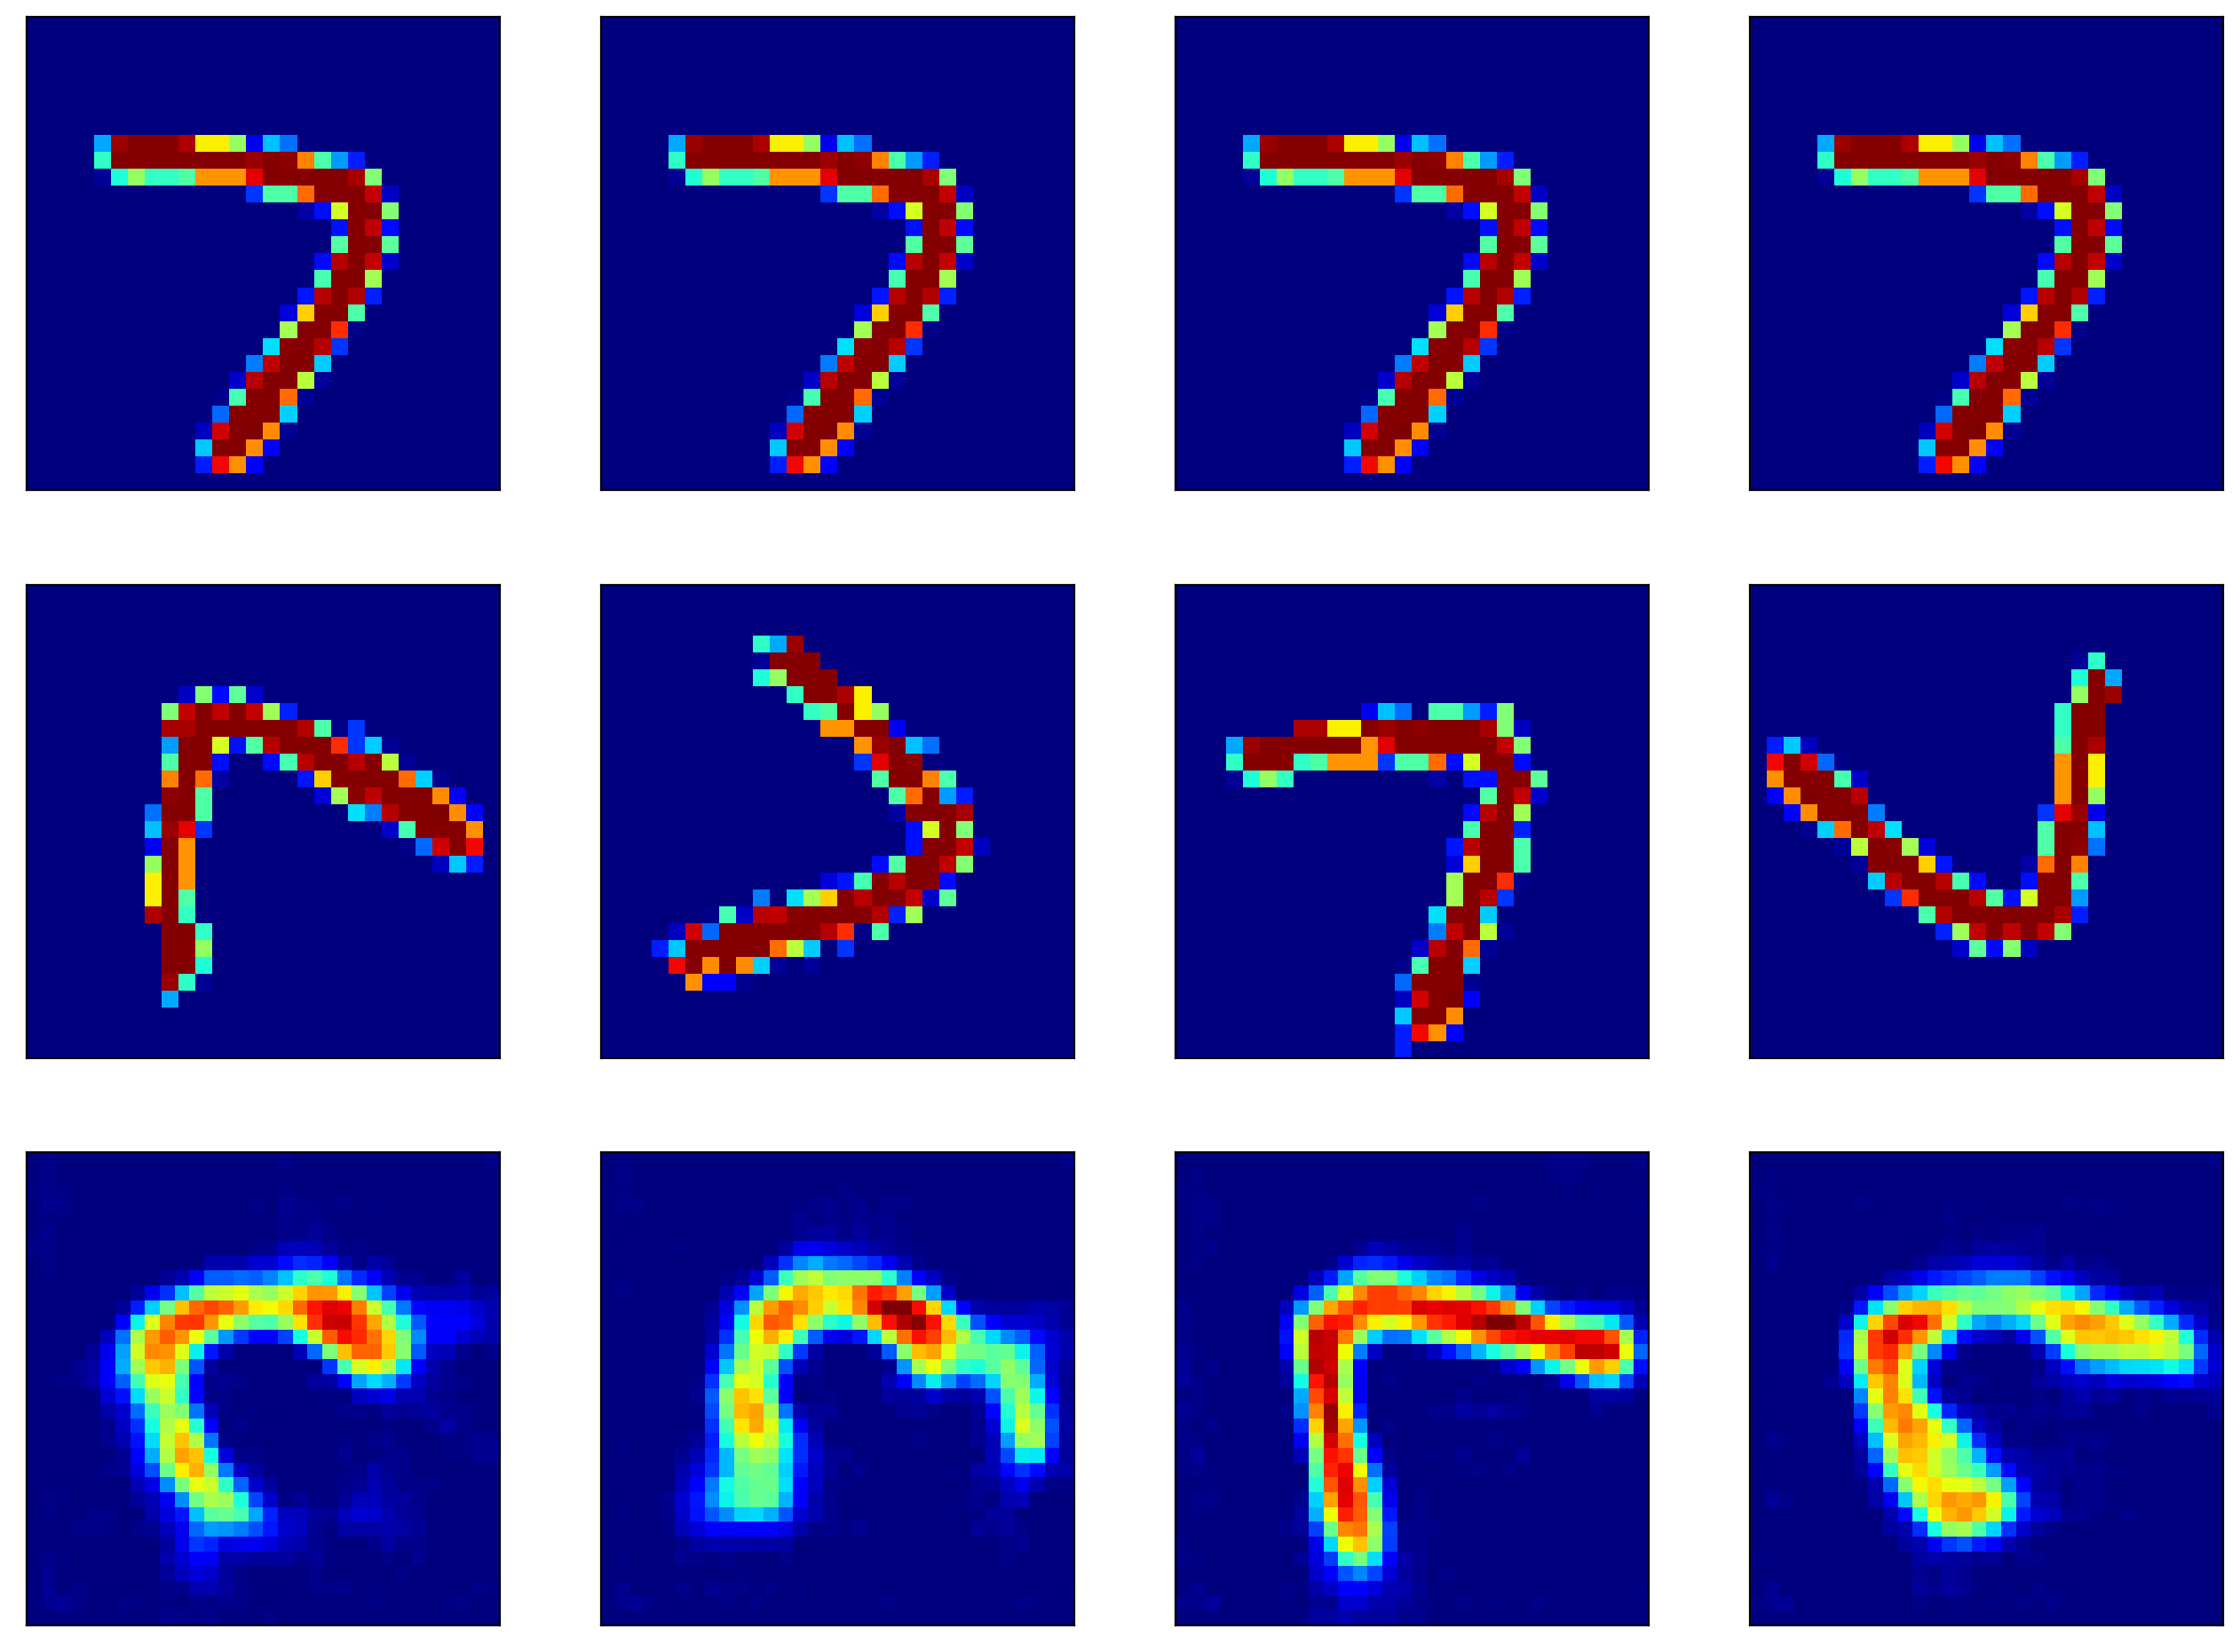


 ### 6938960 0.1-10 ### 



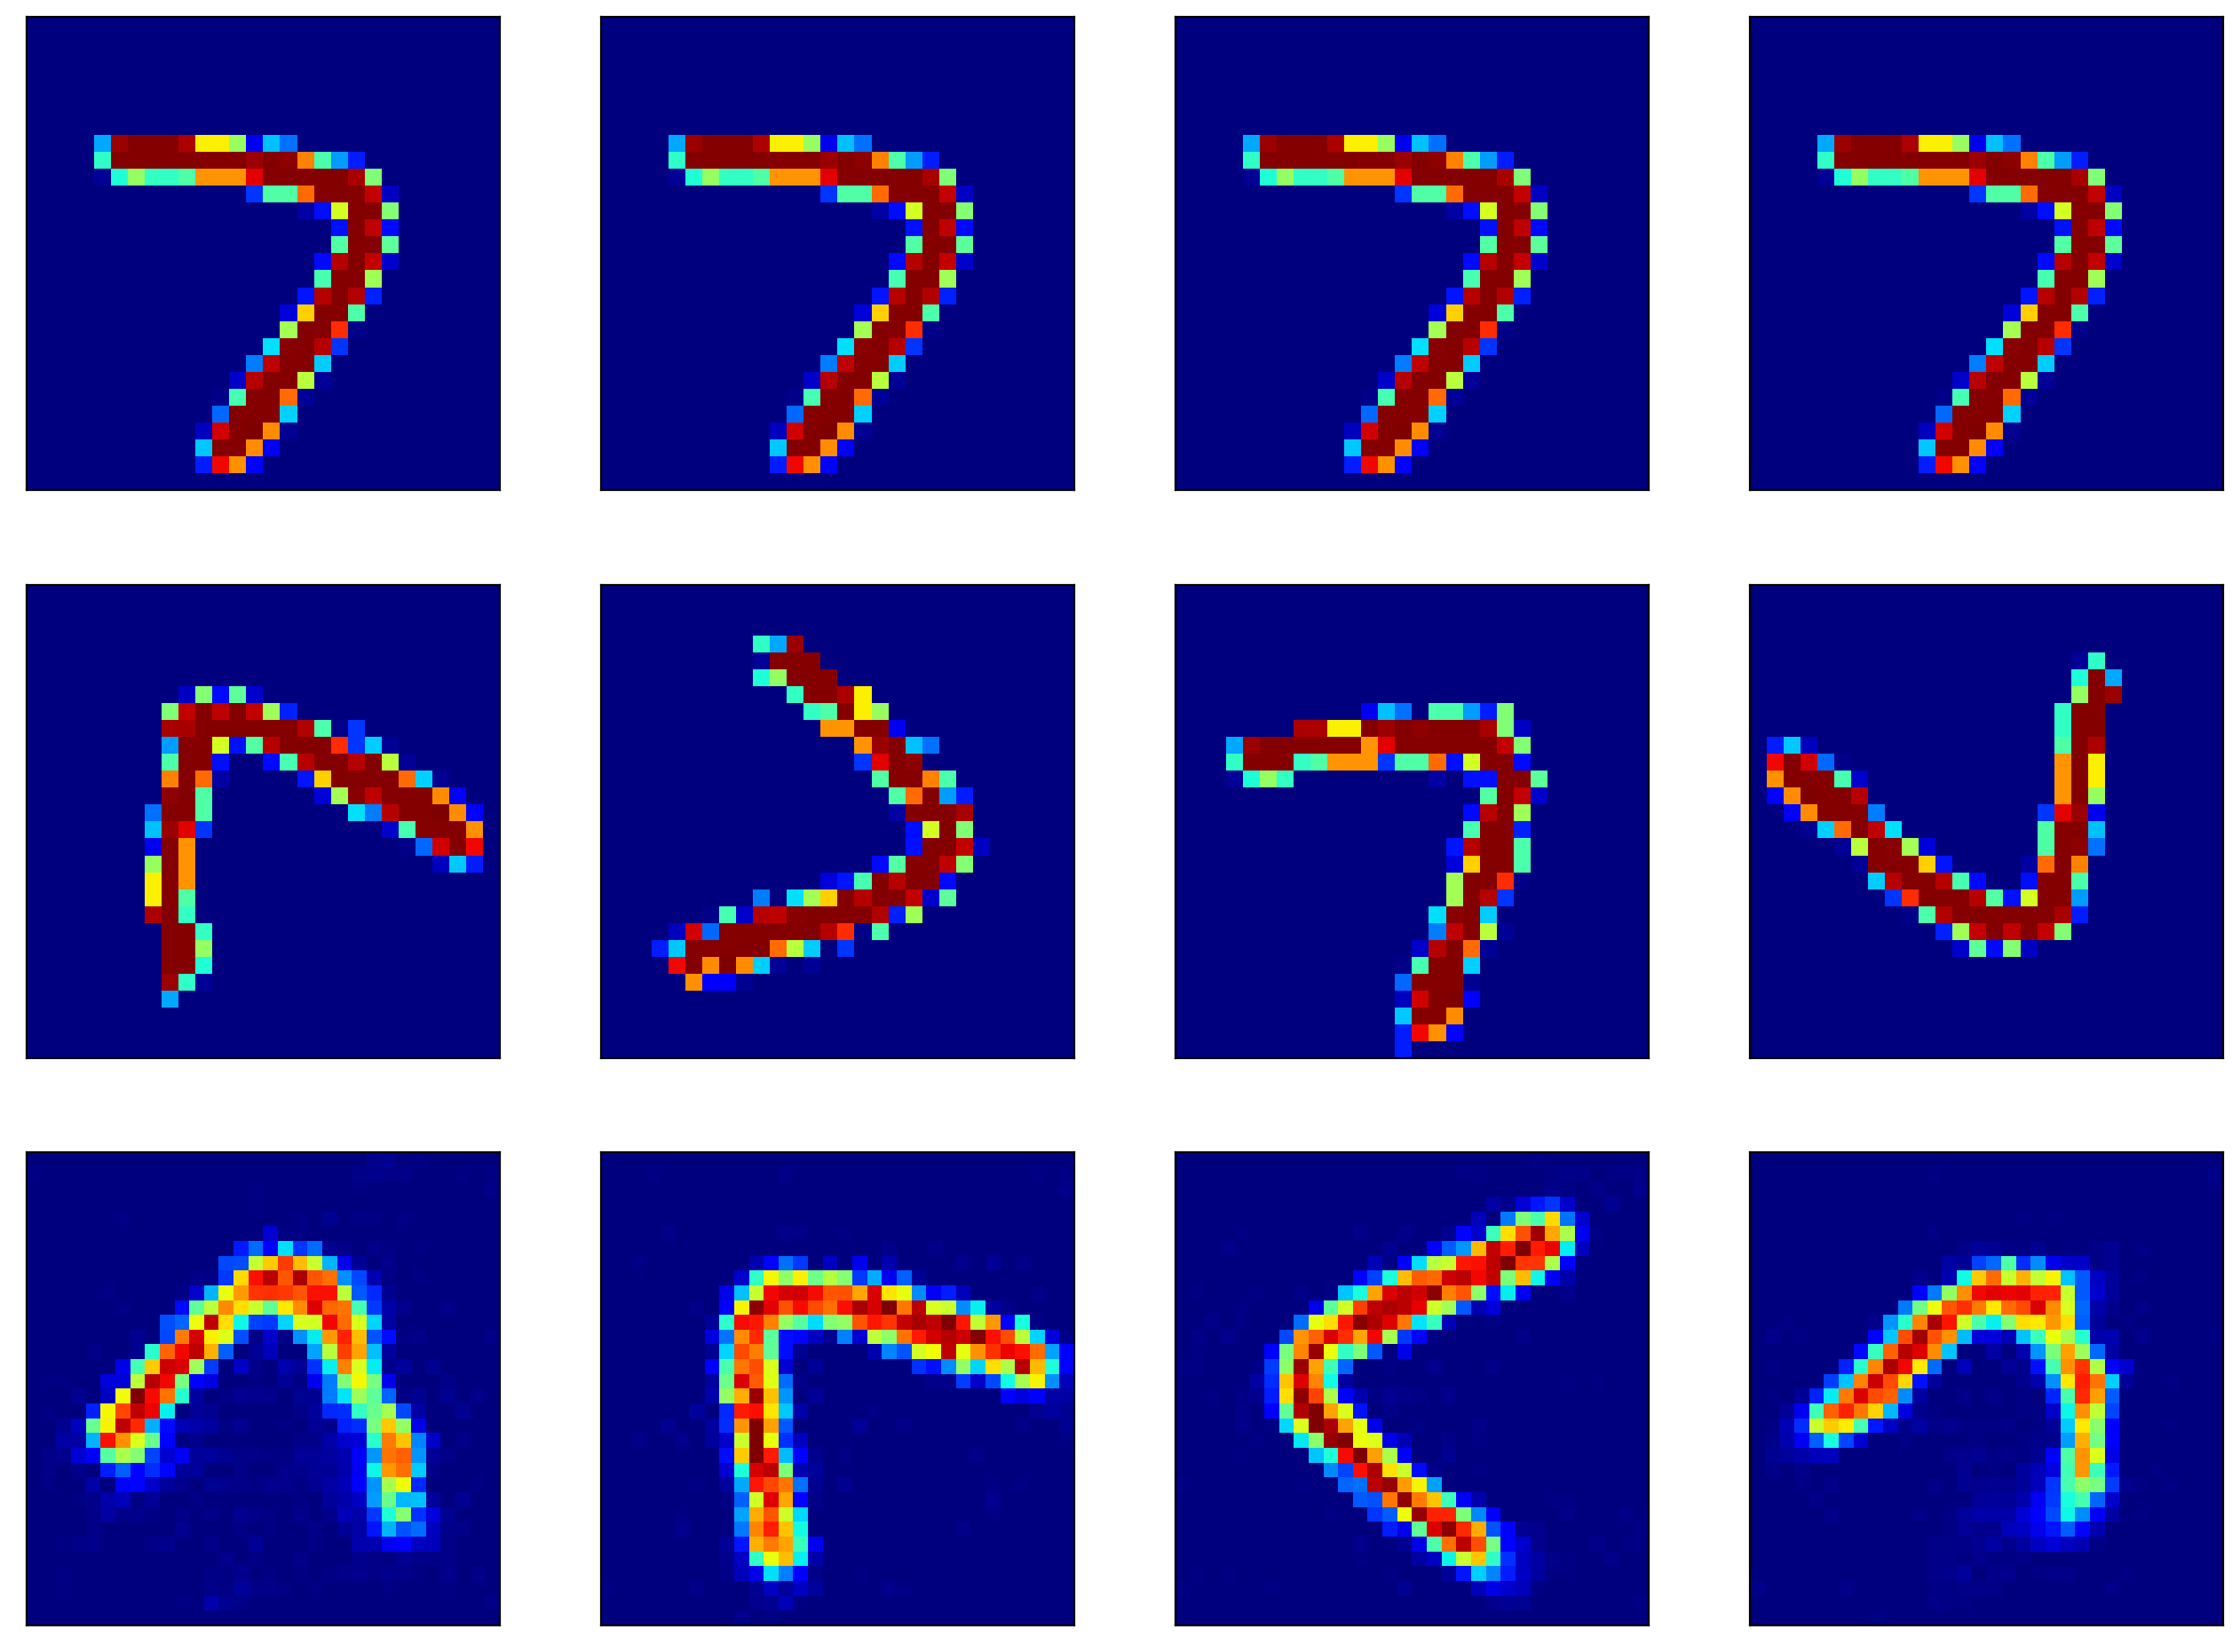


 ### 66046429 1-0.1 ### 



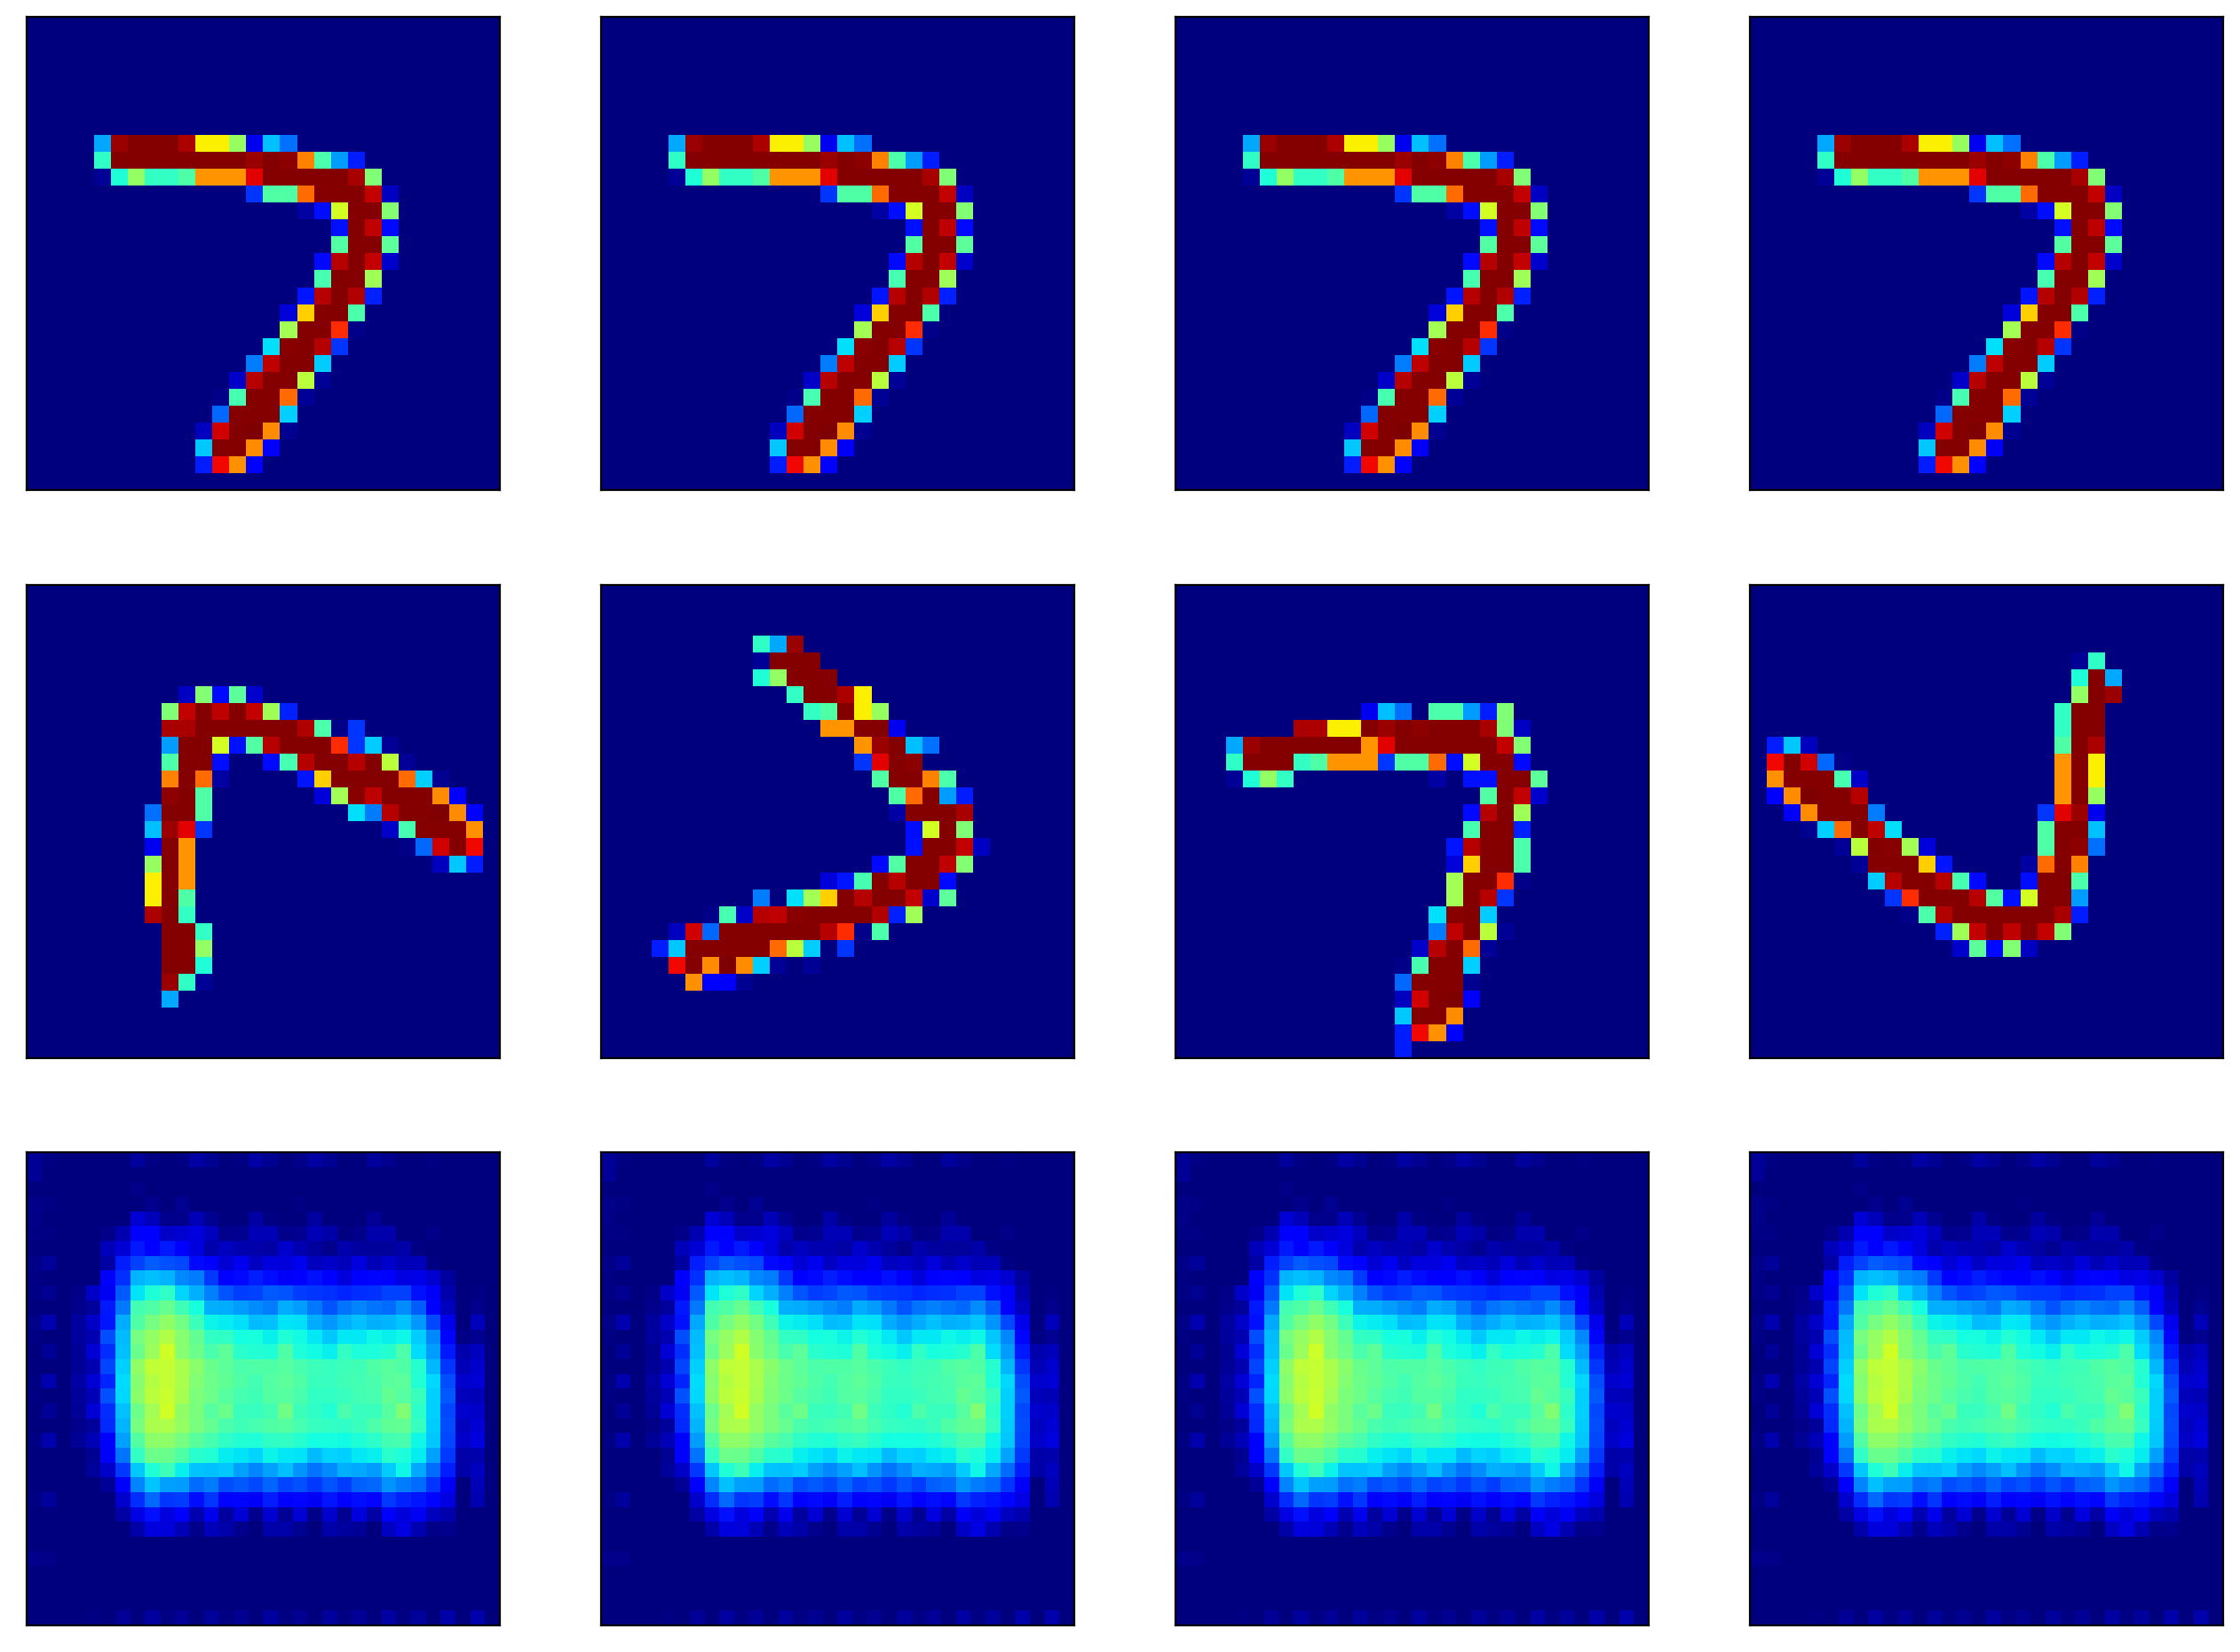


 ### 65952364 1-1 ### 



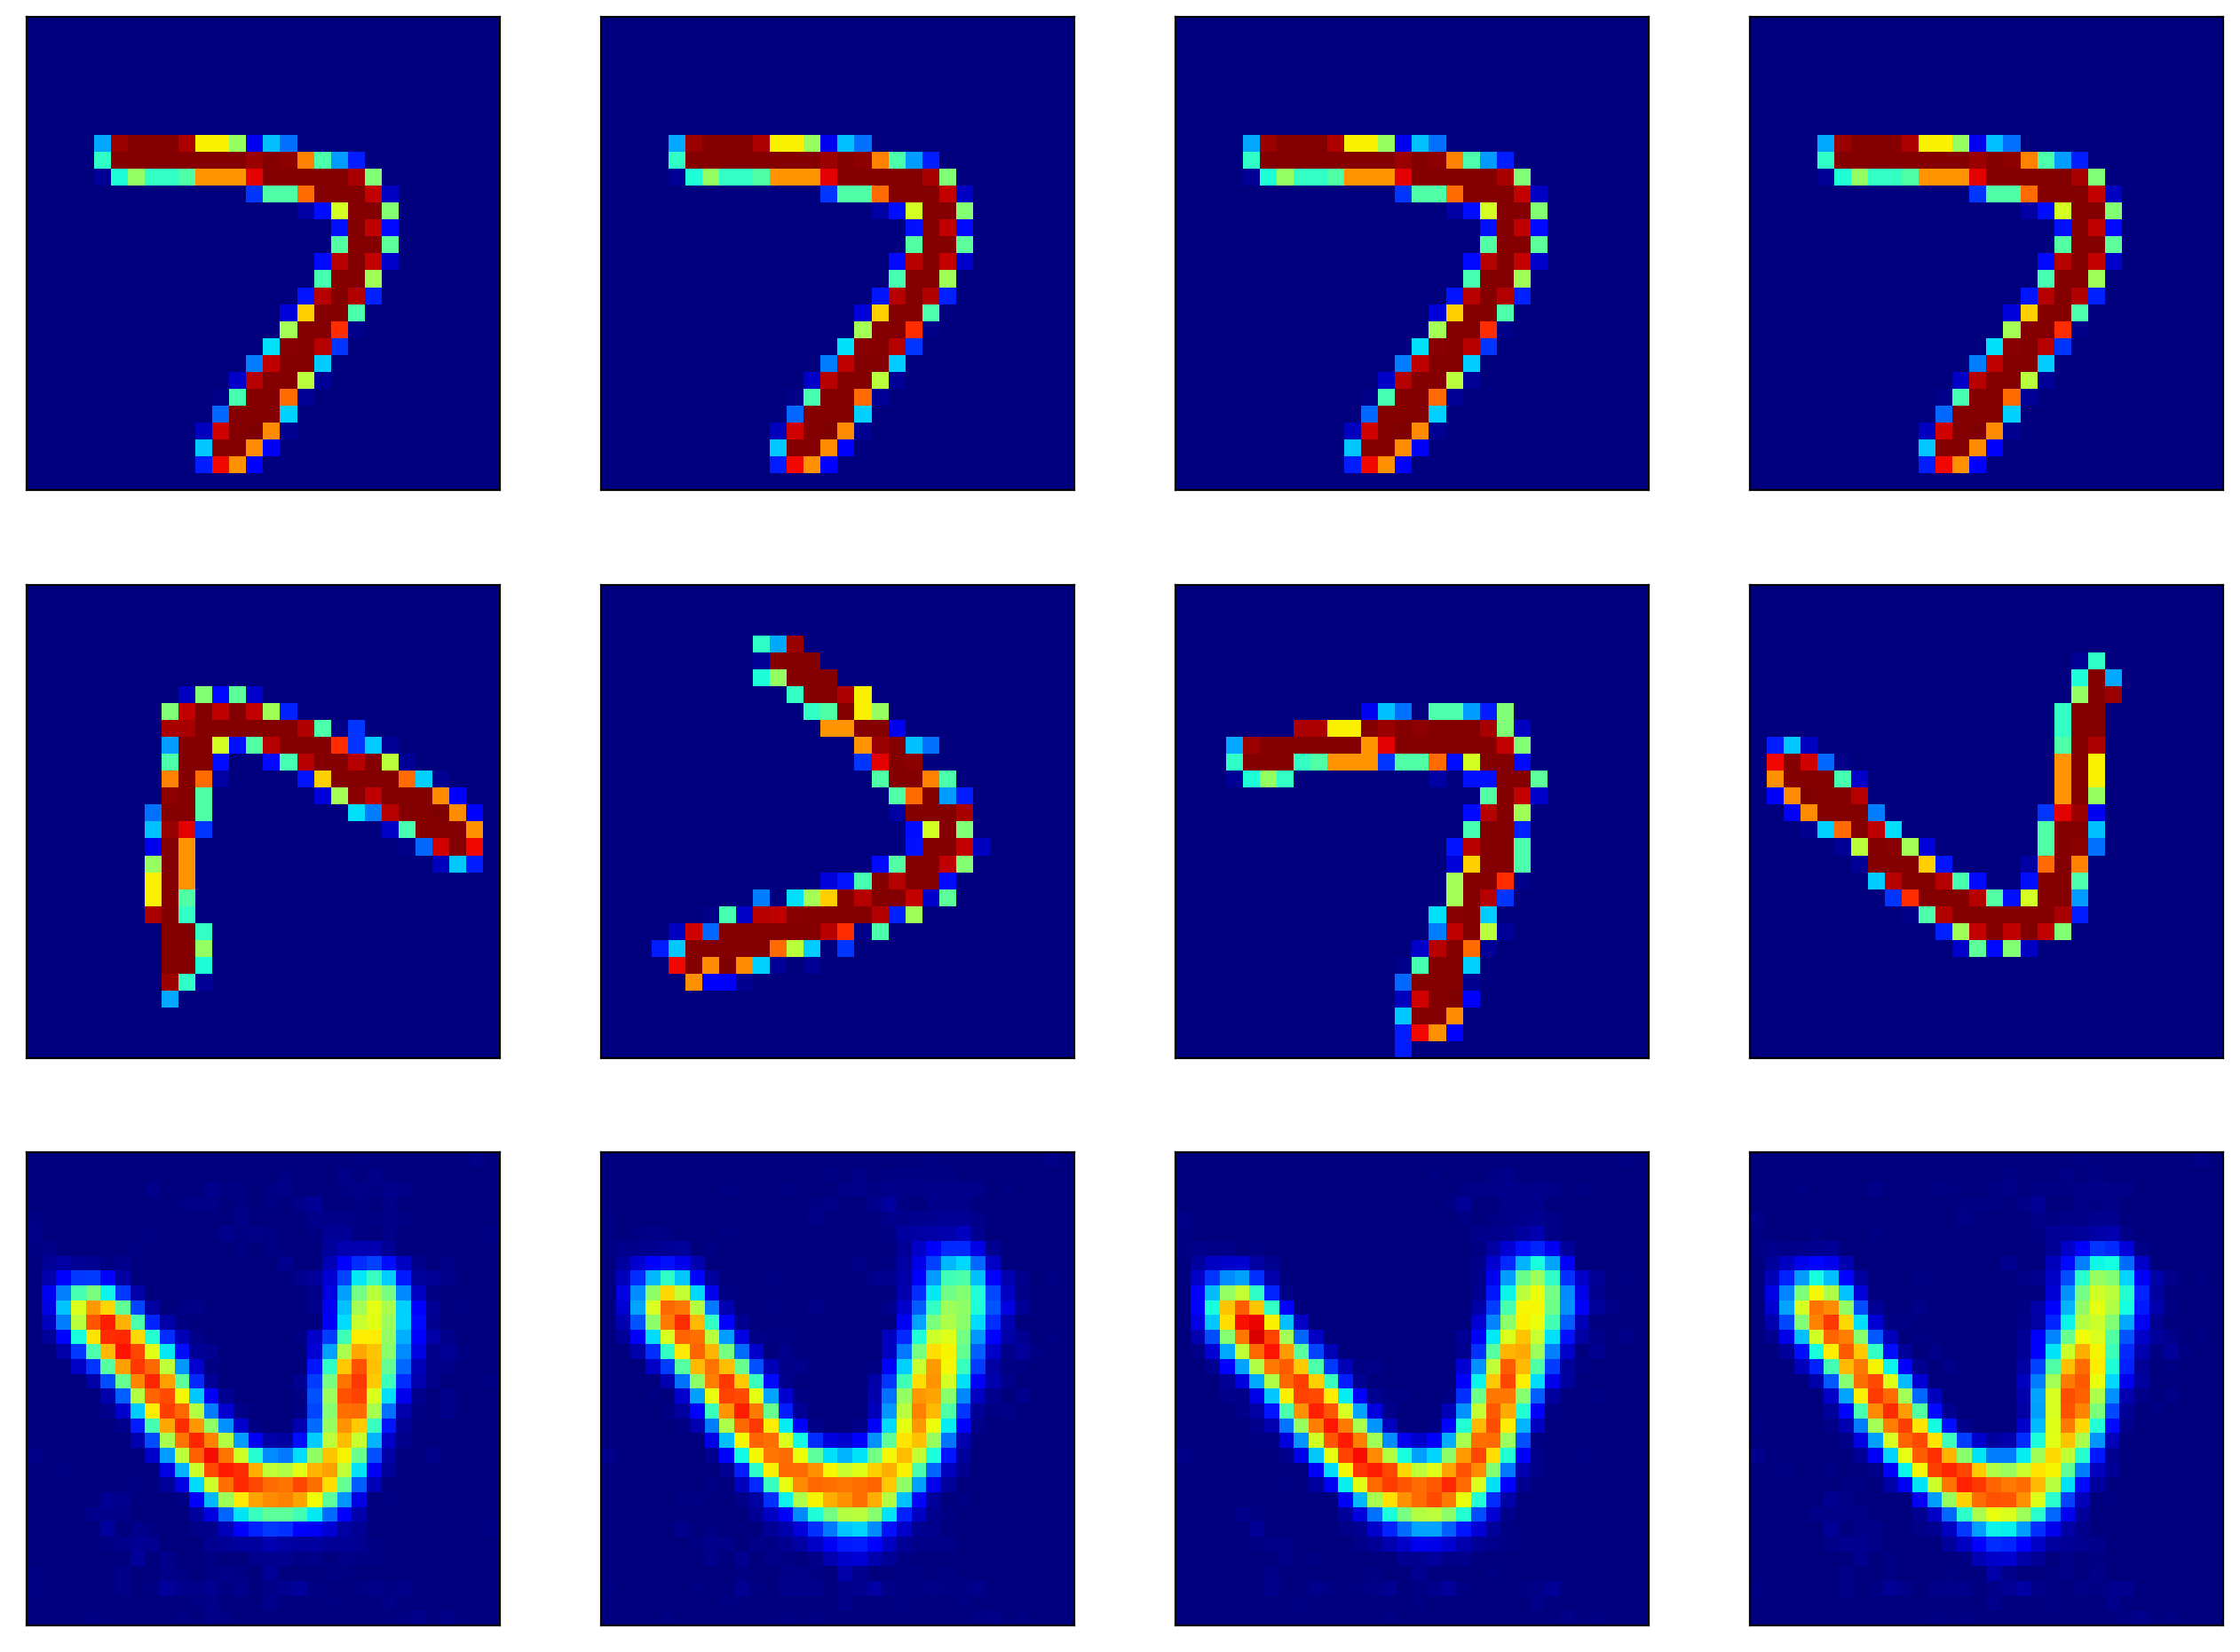


 ### 65953273 1-10 ### 



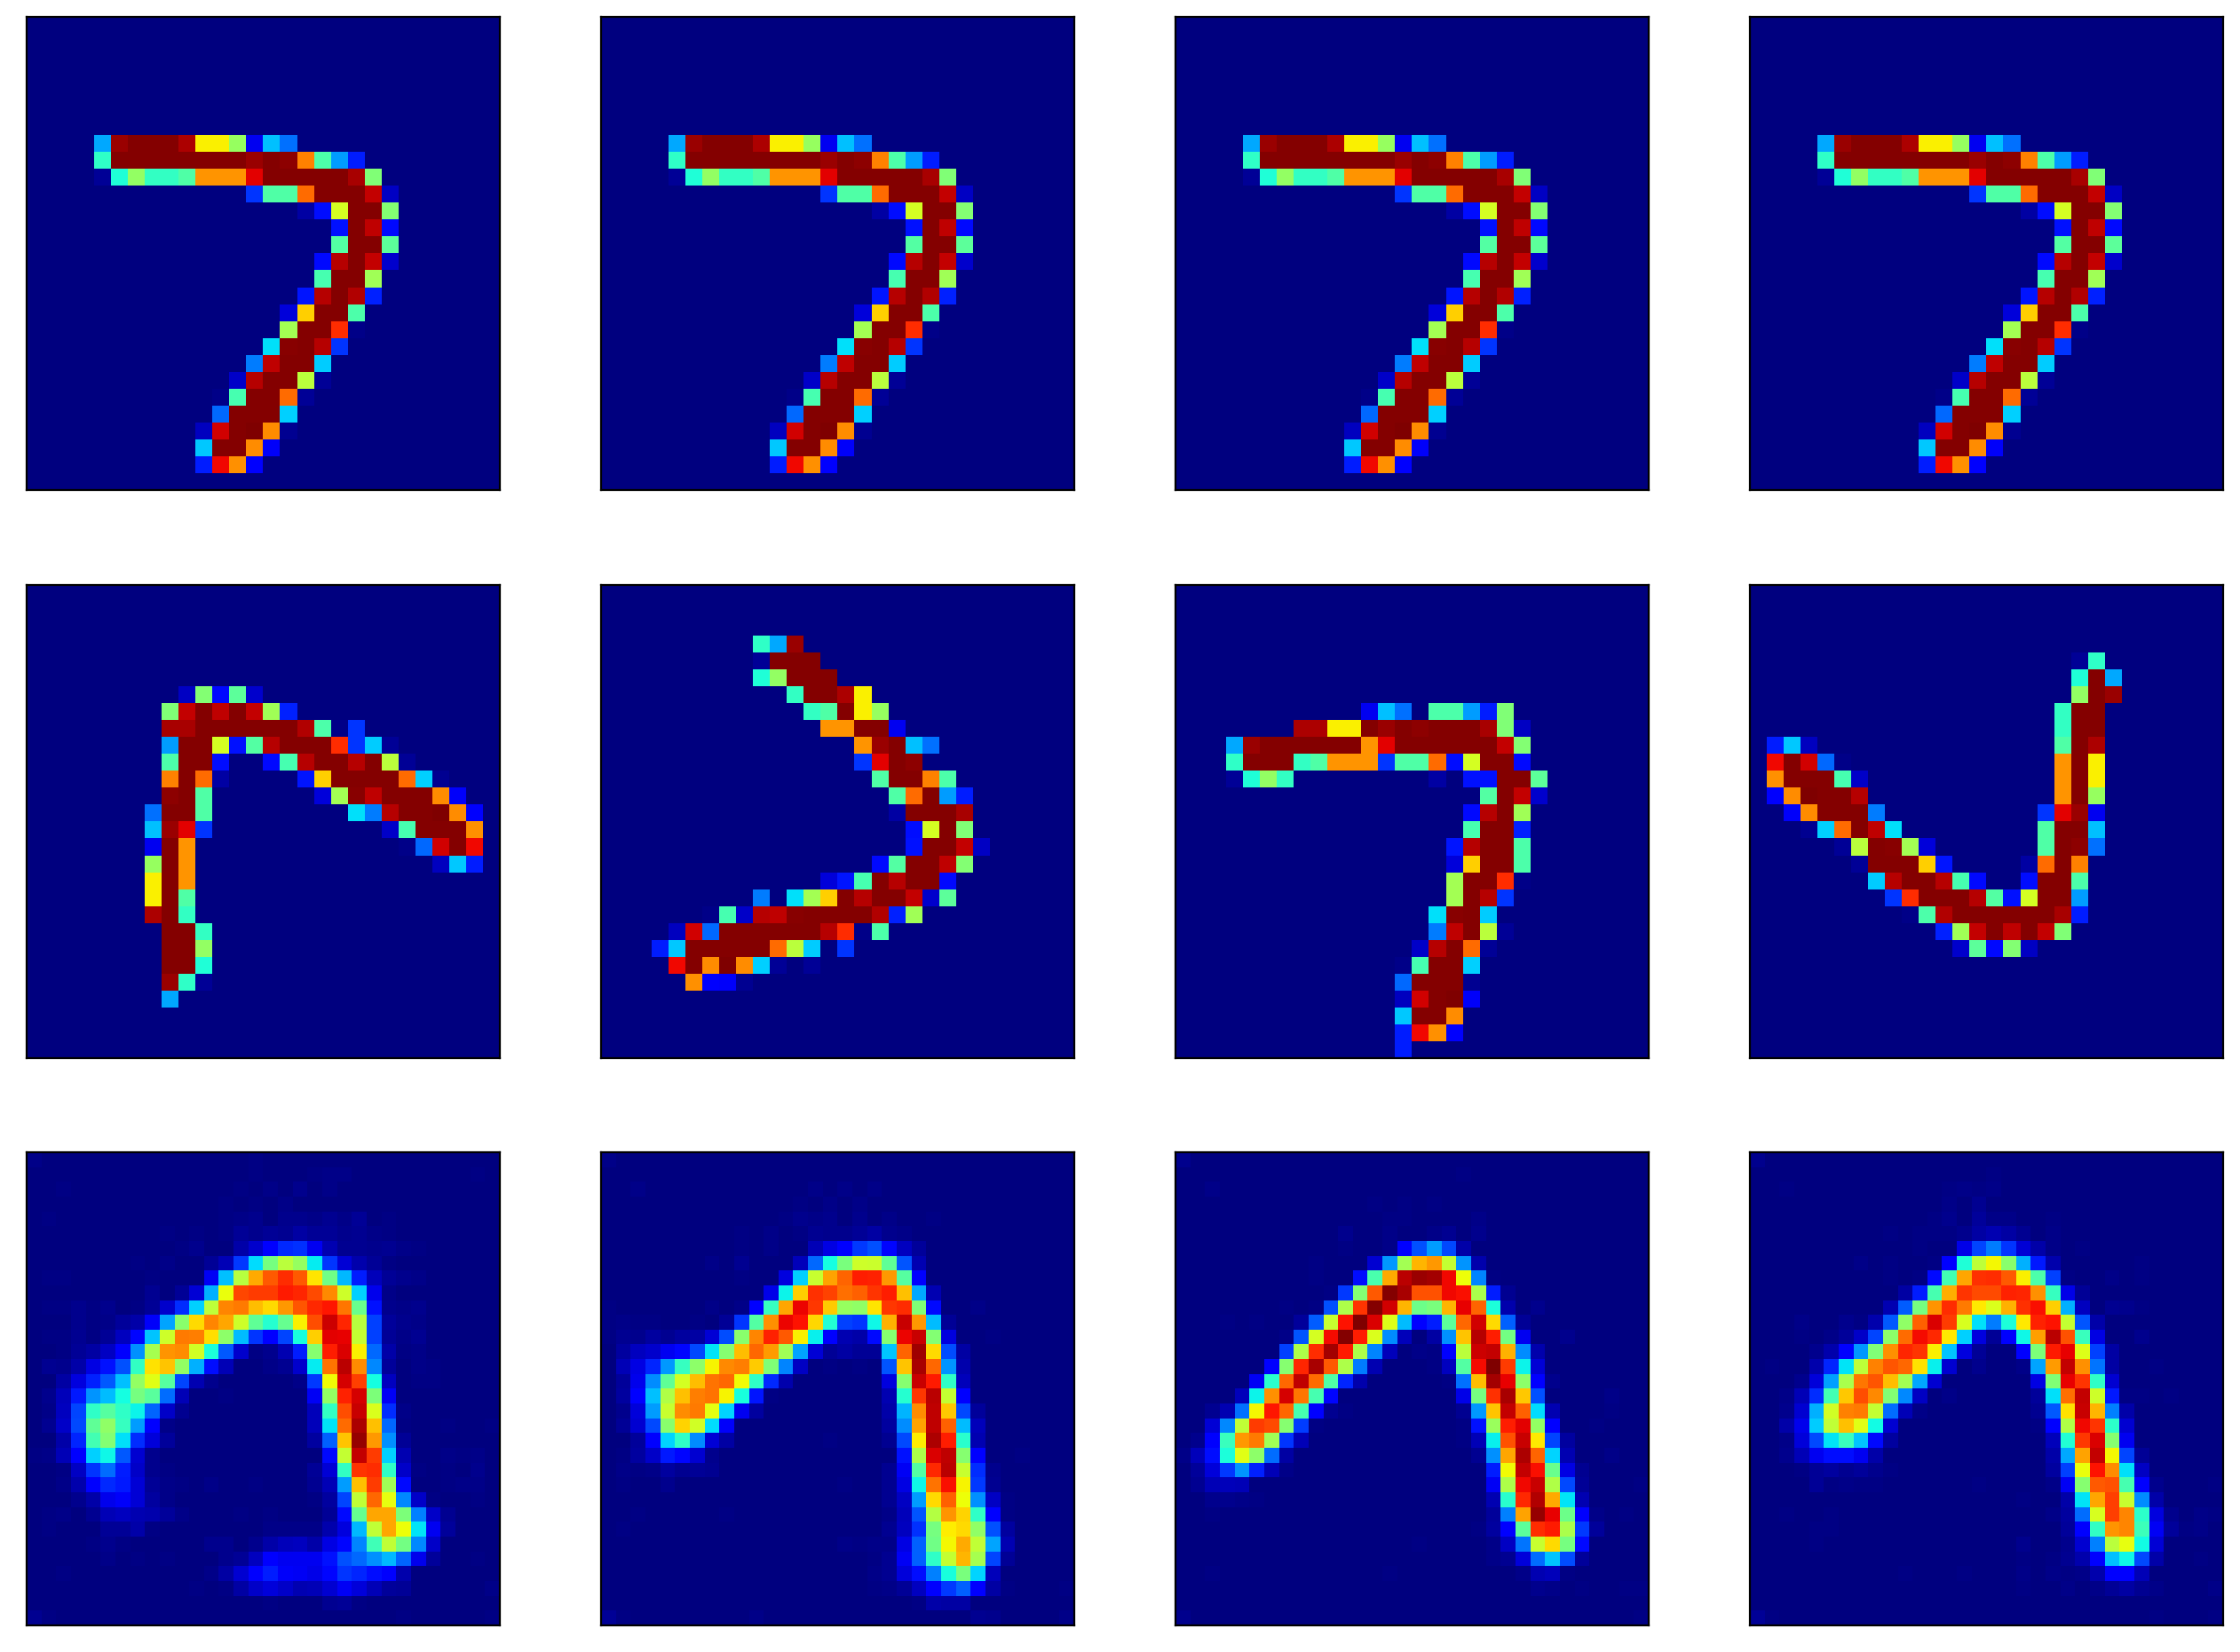


 ### 6938956 10-0.1 ### 



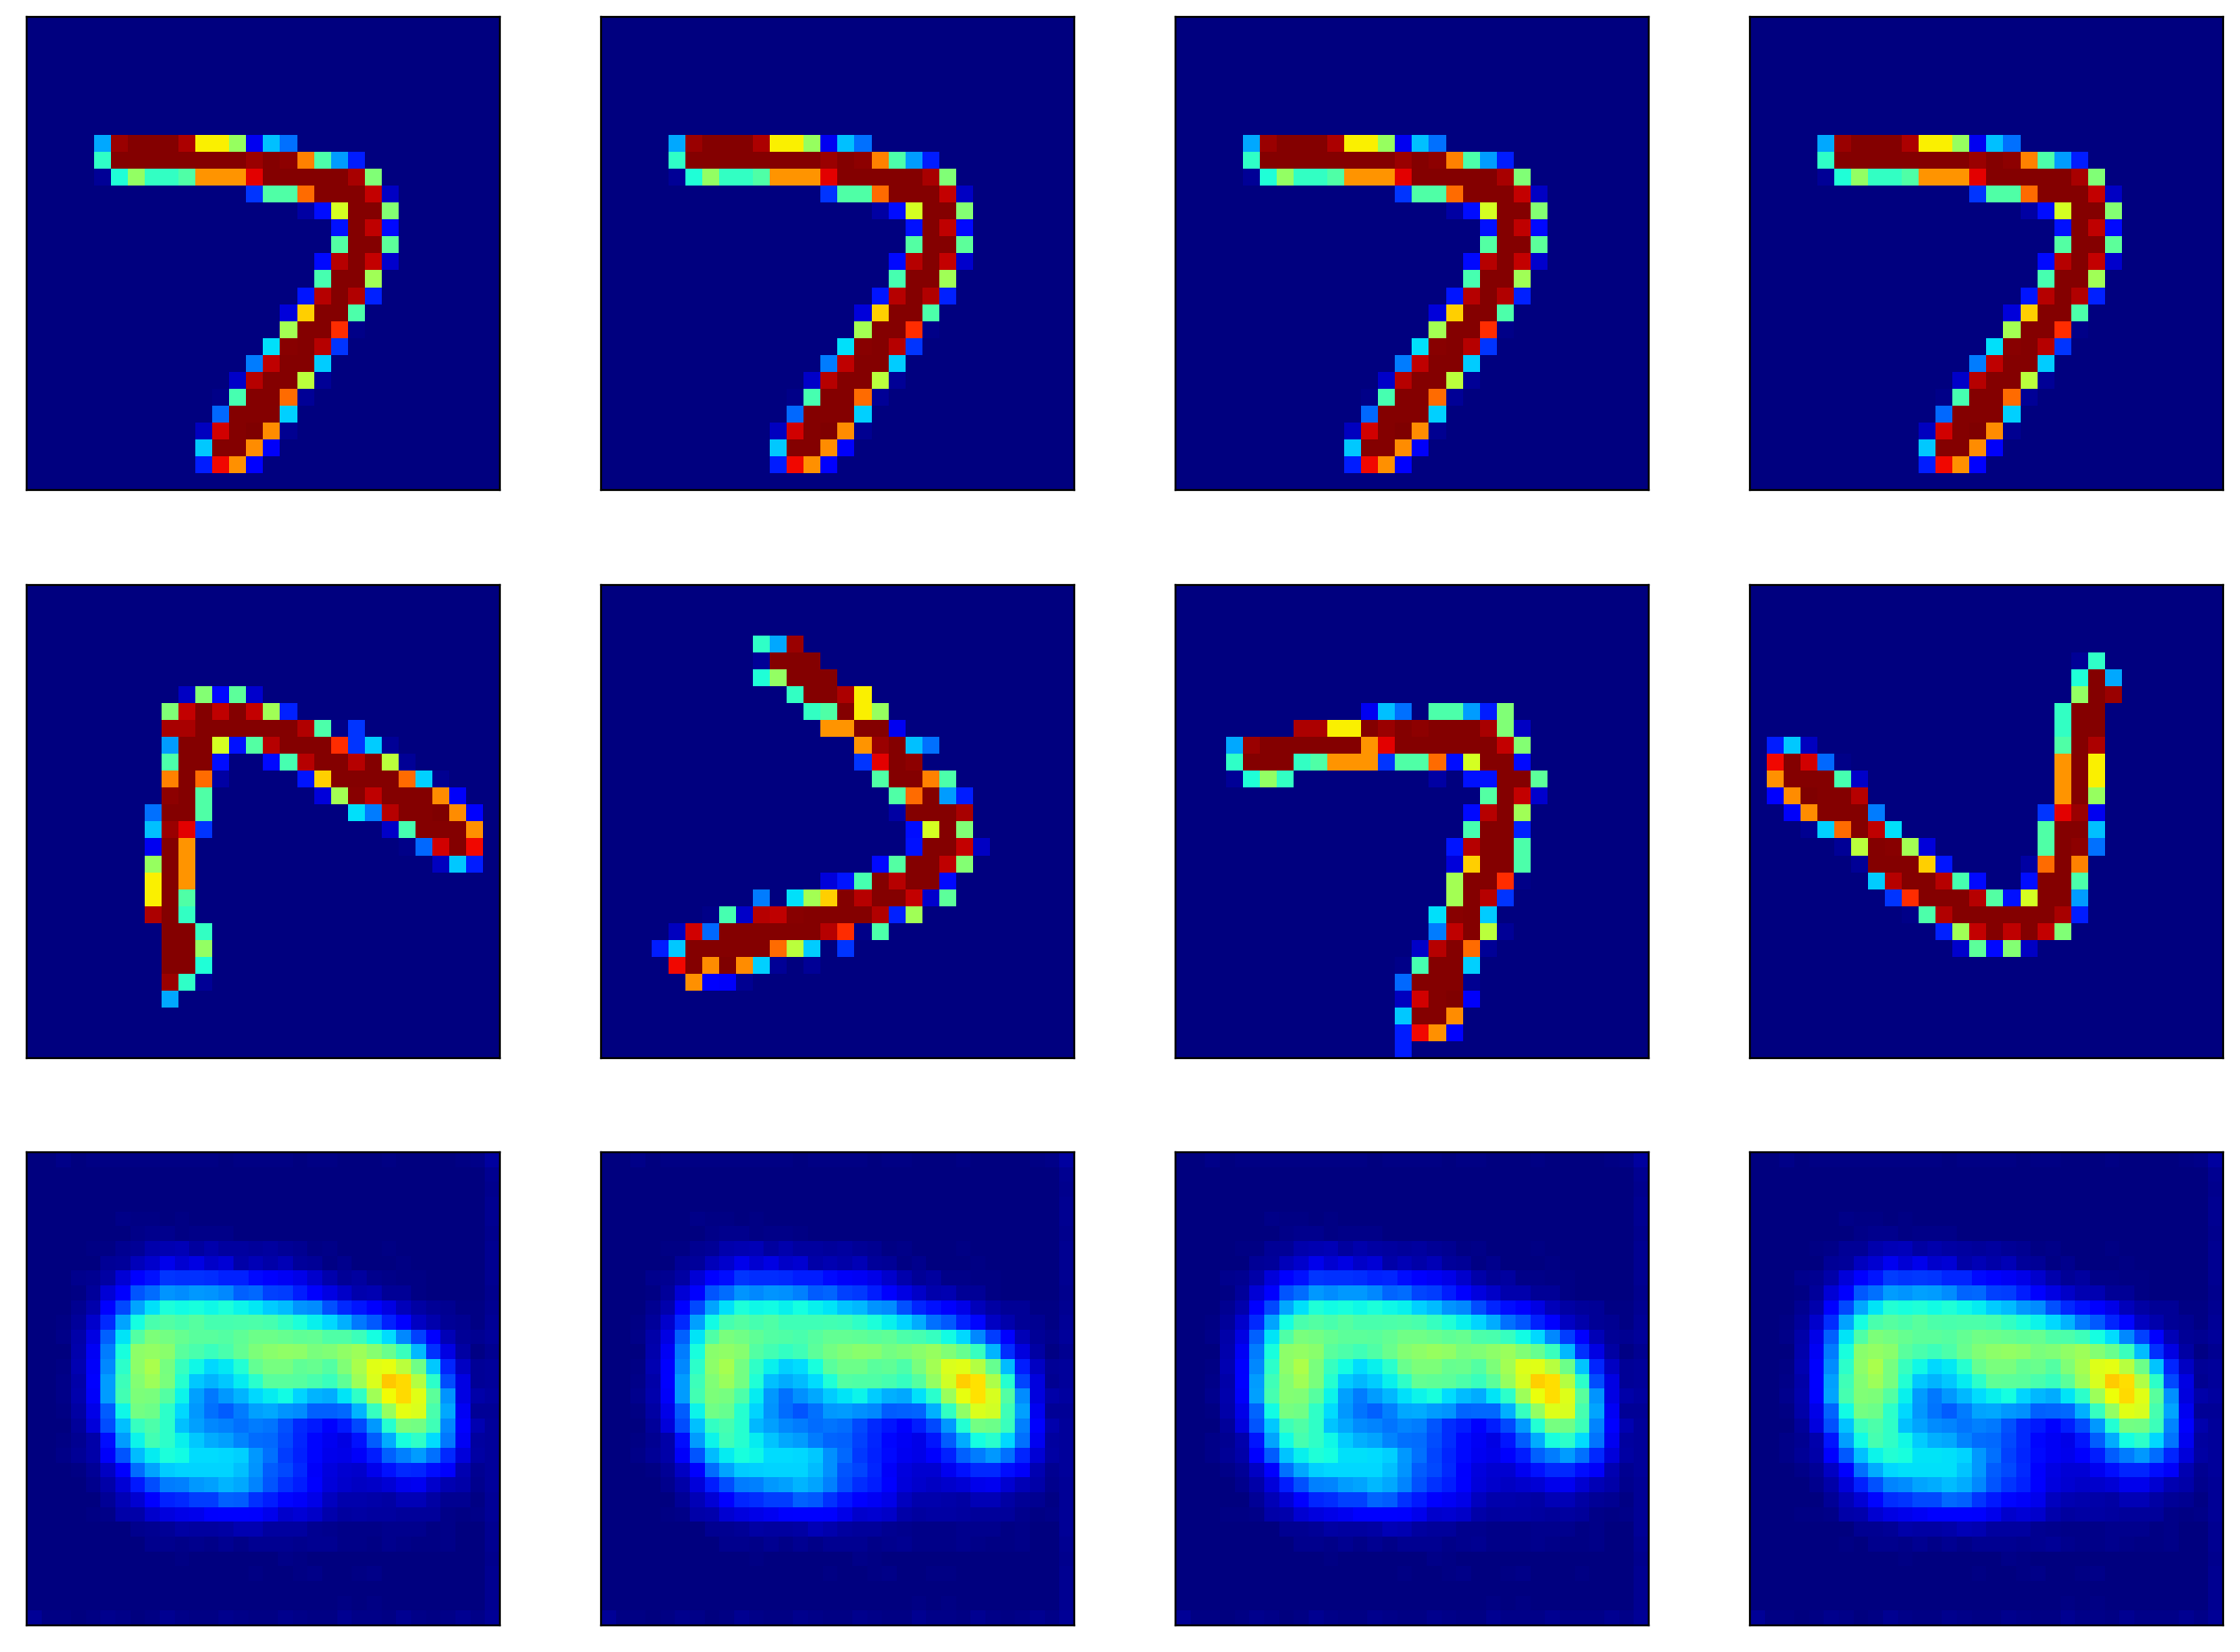


 ### 66030707 10-1 ### 



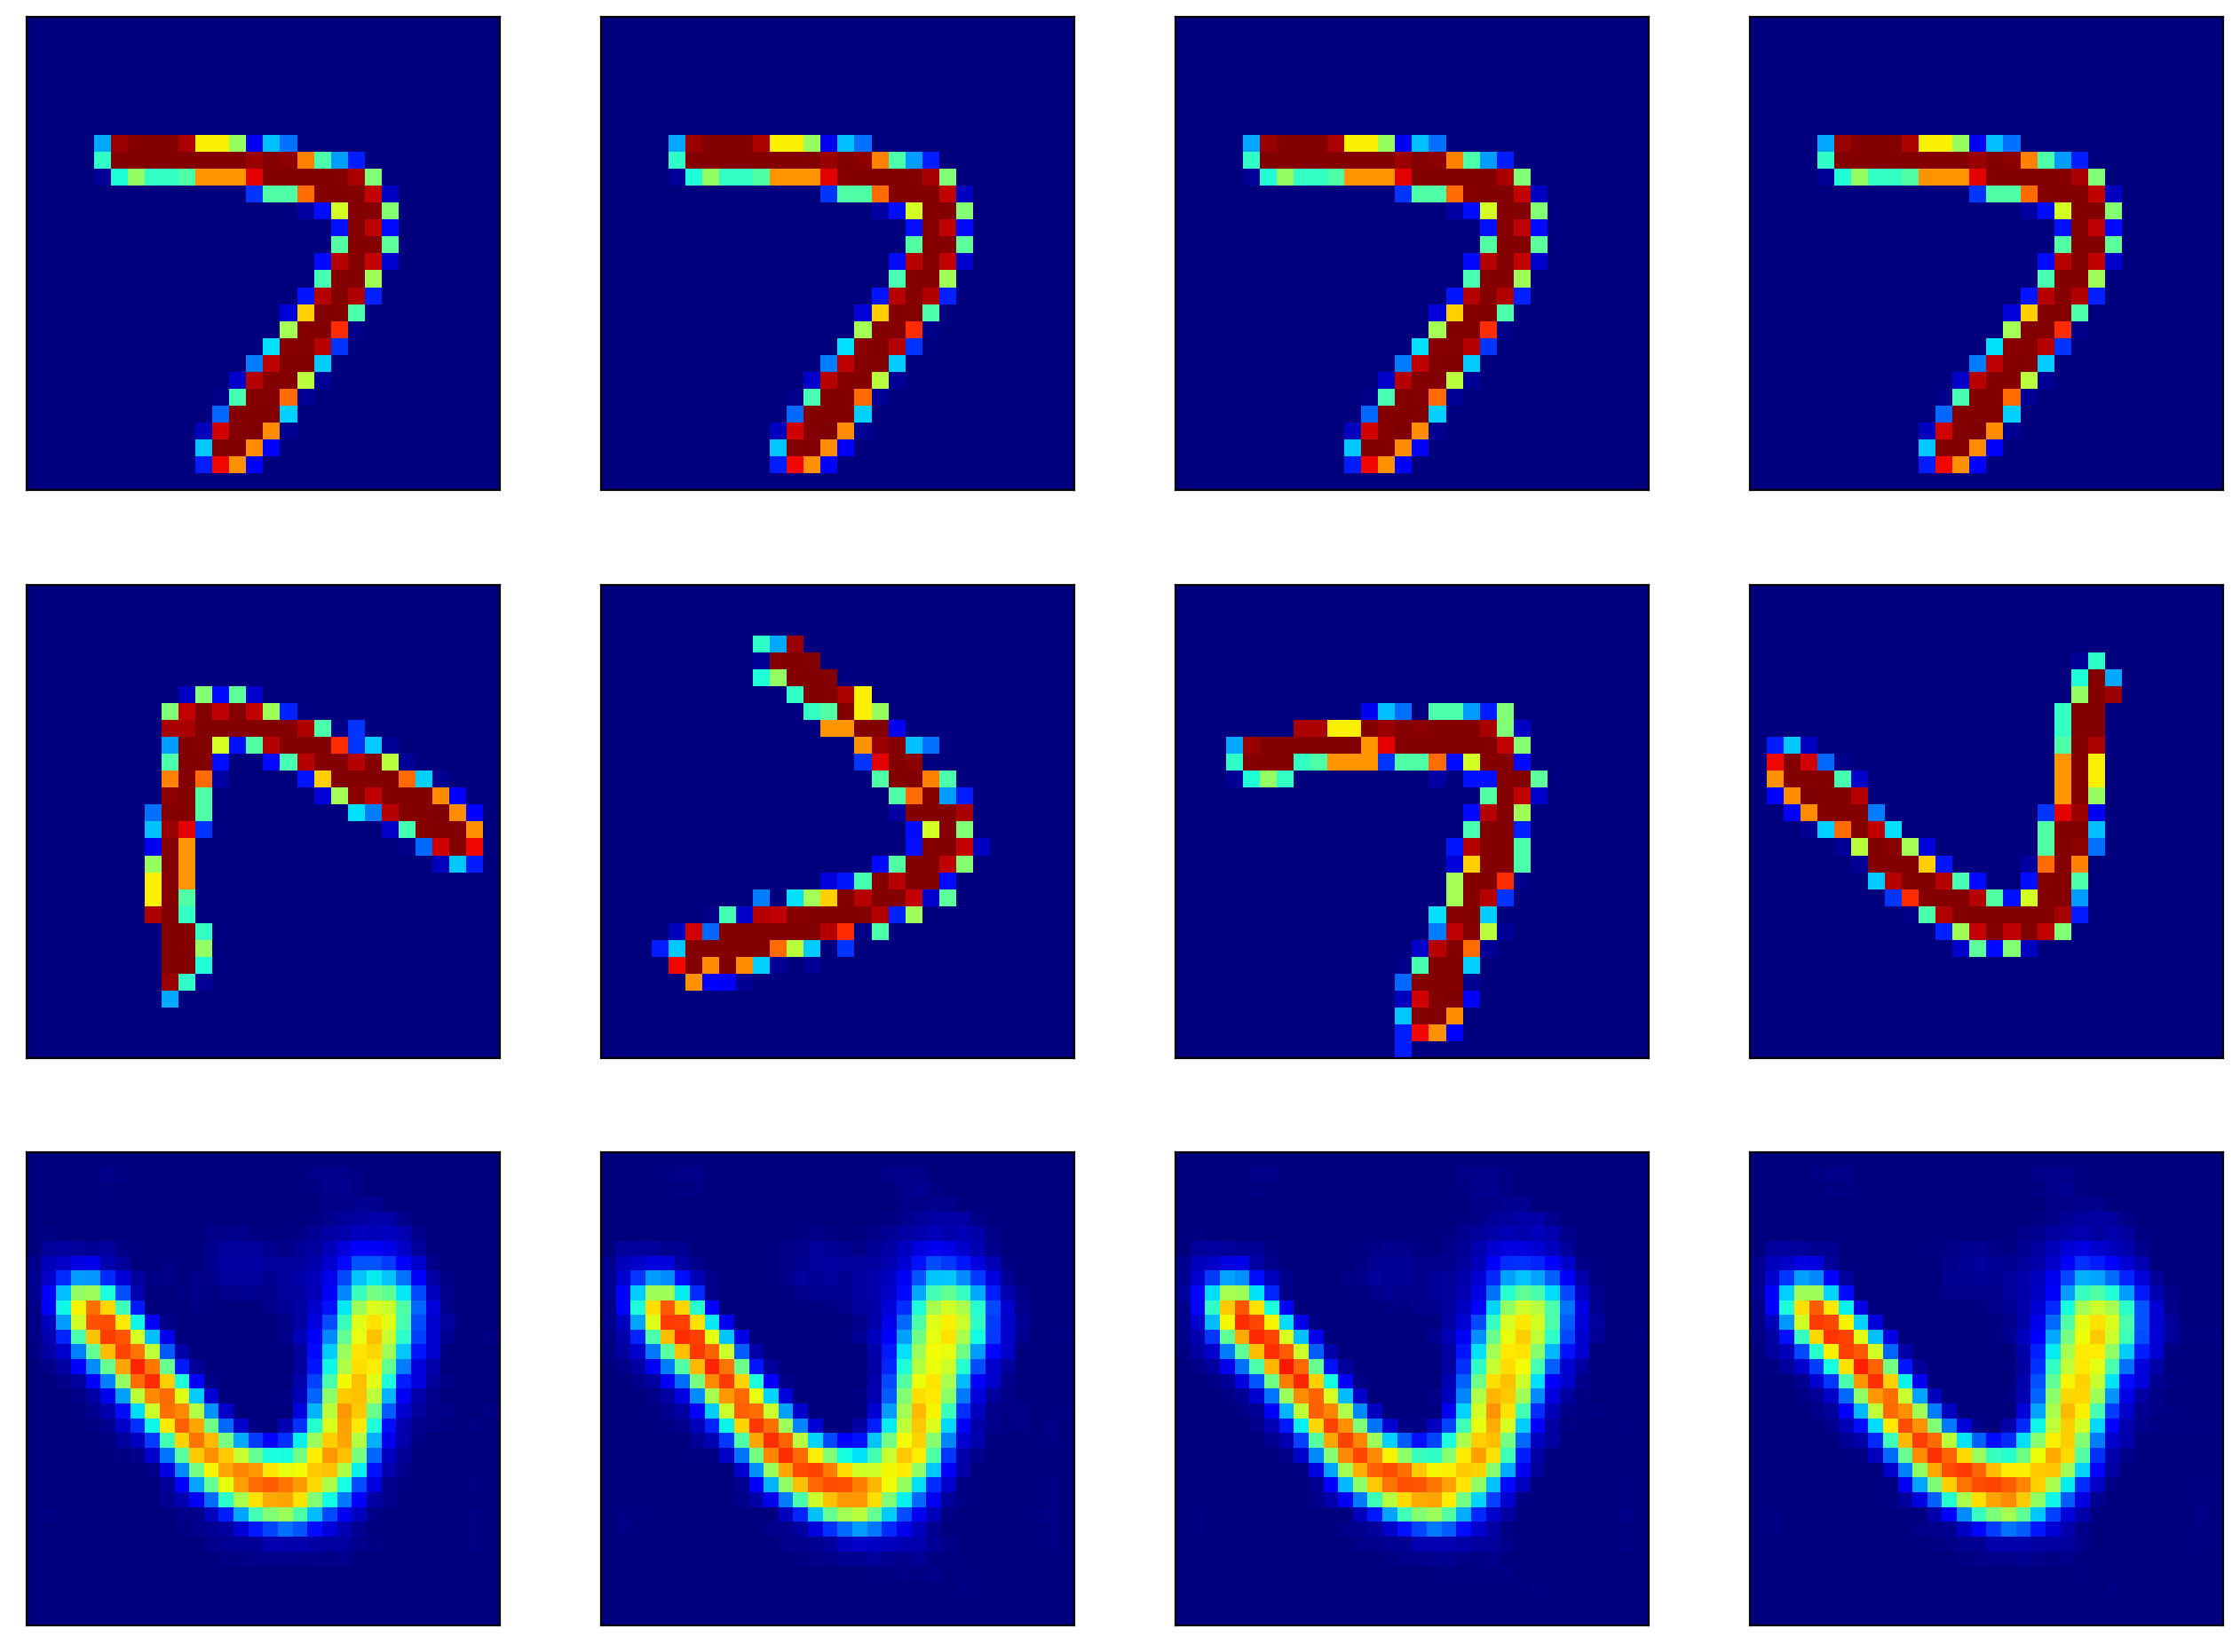


 ### 6938958 10-10 ### 



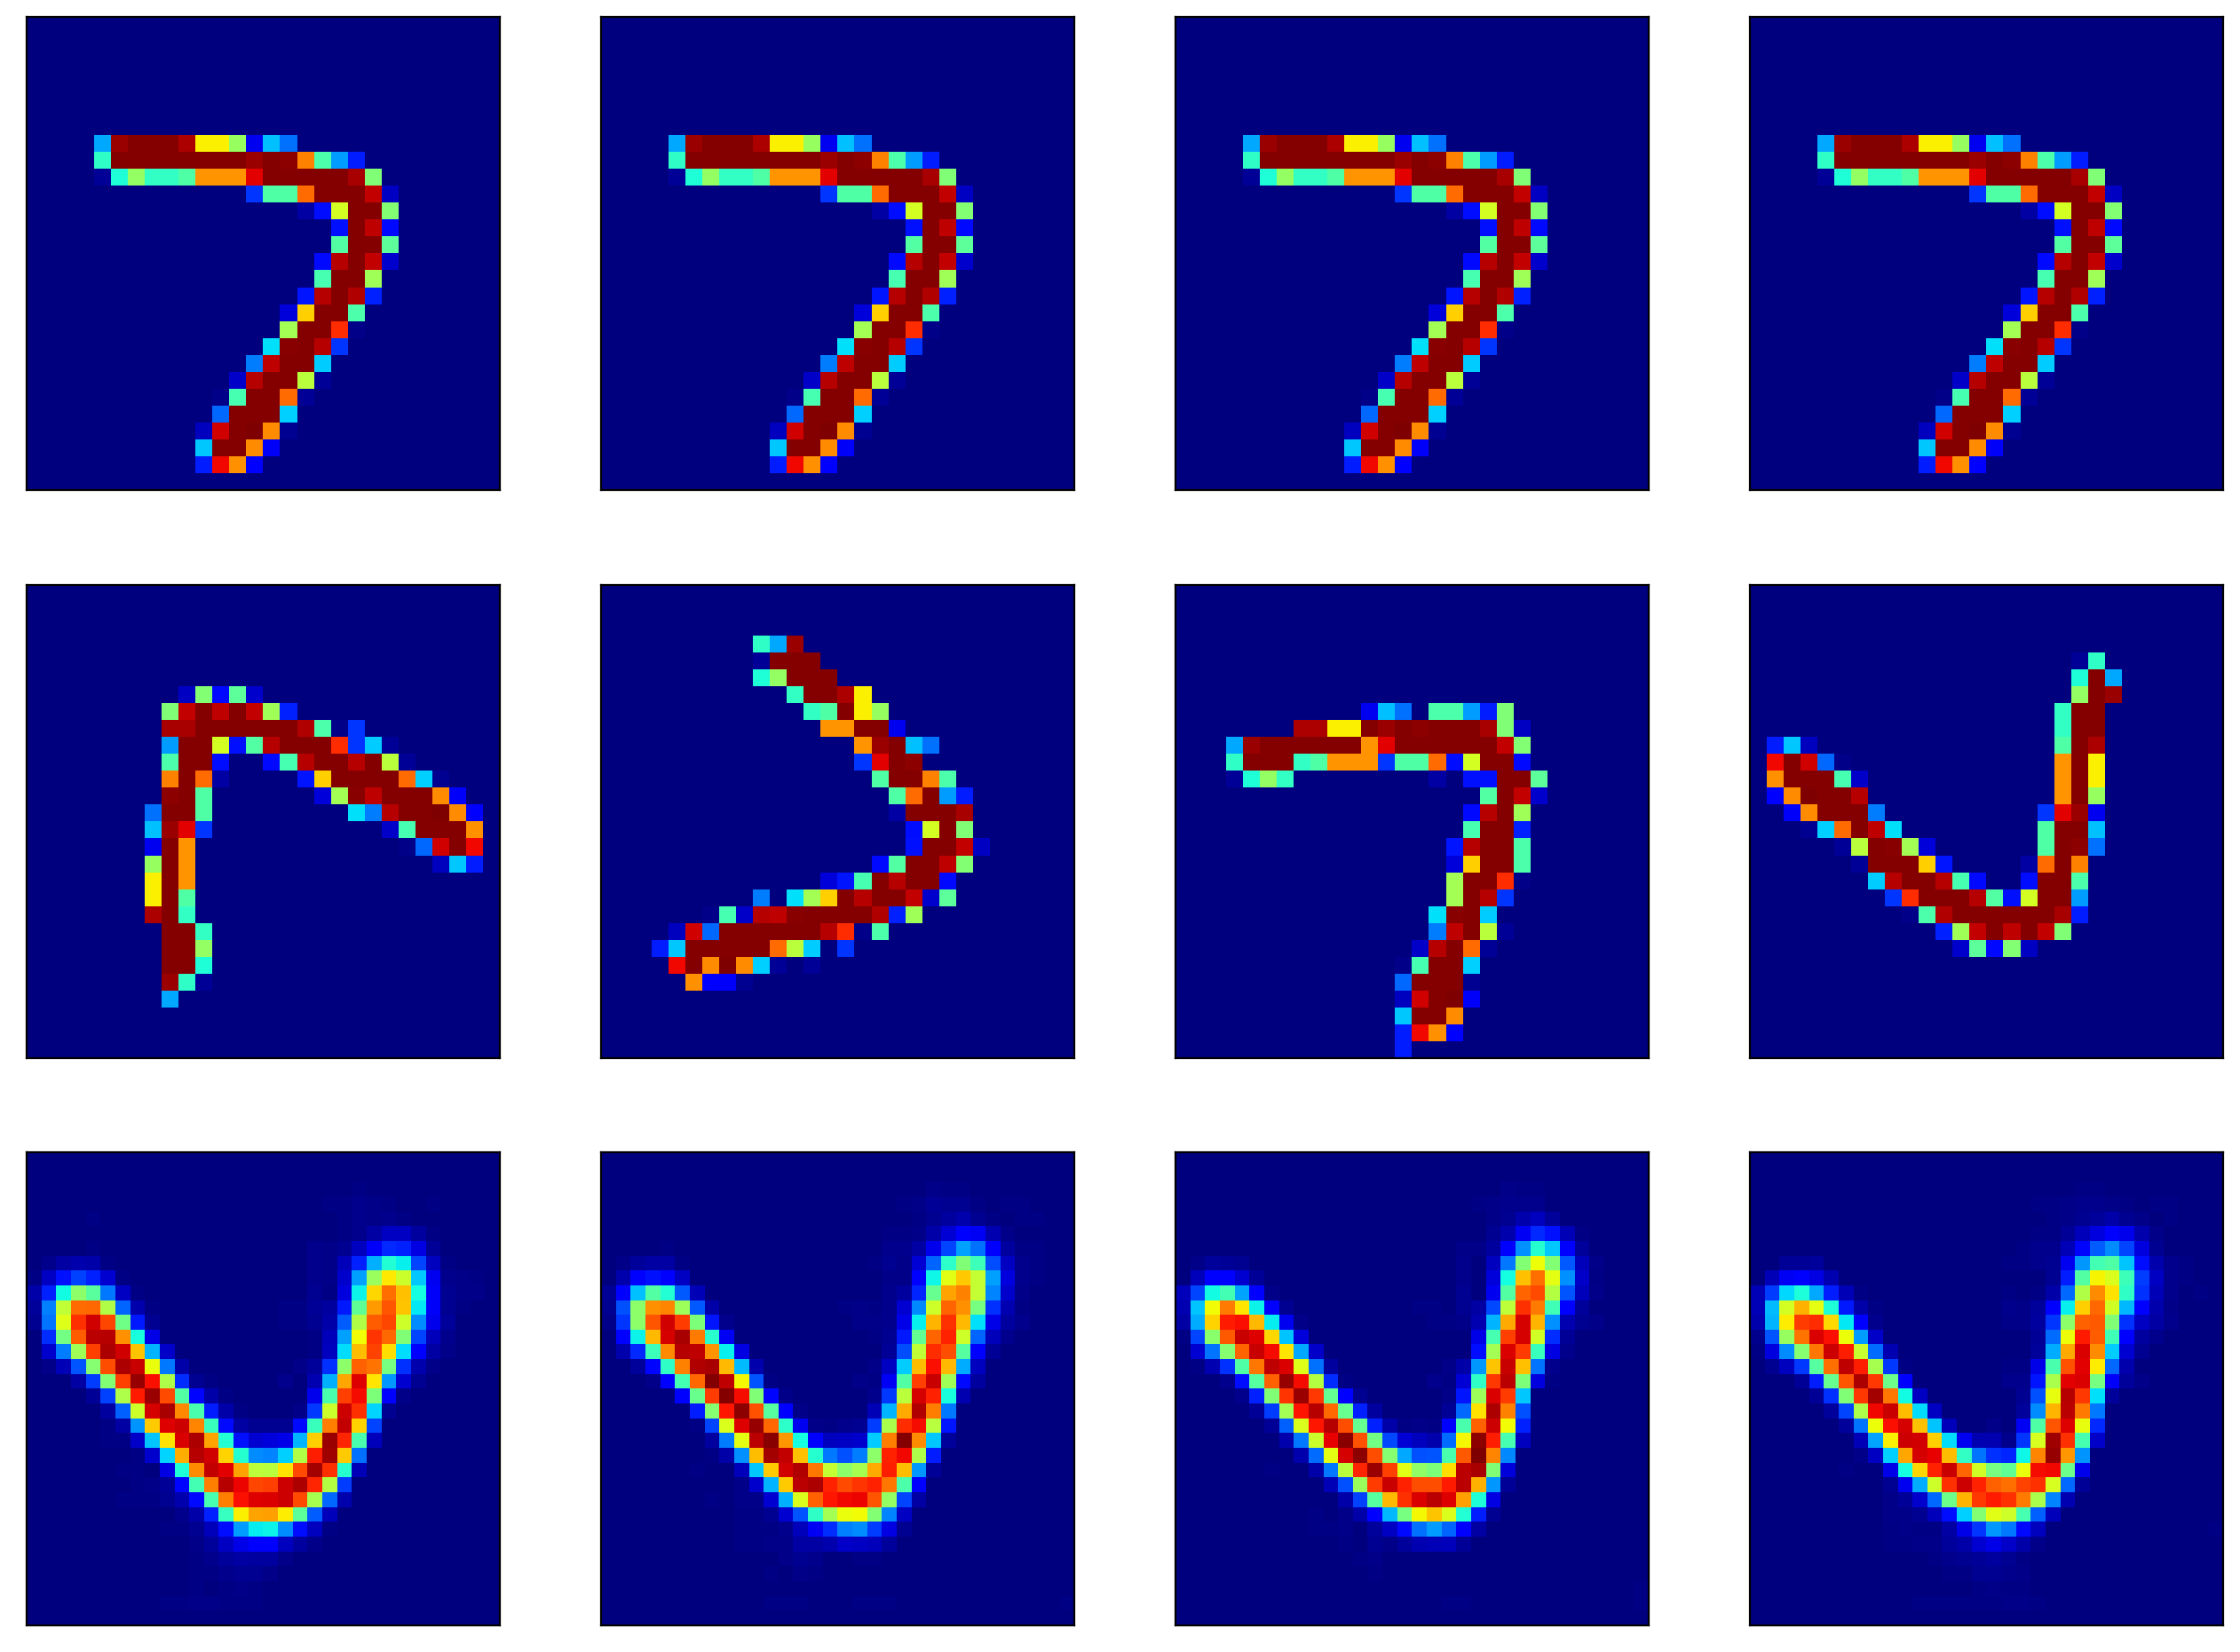

In [241]:
for i, ikey in enumerate(outputs.keys()):
    print(f"\n ### {ikey} {inv_param_dict[ikey]} ### \n")
    tplot_fn(imgs=x_test, simgs=osimgs,rimgs=outputs[ikey],num_test_images=4,
             sindex=17, figsize=(16,12),dpi=200,
             xloc=0.03, pfontsize=80, yys=np.linspace(0.12, 0.76,3),savedir='./figs', savename='xxx.pdf',
             label_on=True,labels=['Original', 'Inputs', 'Restoration'], yfontsize=30)

In [106]:
def mpl_plotGridSearchResults(imgs_dict,expnames_dict={},
                              lambda_inv_list=[], lambda_res_list=[], 
                              copy_size=2,figsize=None, savedir=None, savename=None):
    # visualization
    fig, ax = plt.subplots(len(lambda_inv_list),len(lambda_res_list)*copy_size,
                           figsize=figsize)
    idx = 0
    for invdx, lambda_inv in enumerate(lambda_inv_list):
        for resdx, lambda_res in enumerate(lambda_res_list):
            # Get experiment name
            expname = expnames_dict[f"{lambda_inv}-{lambda_res}"]
            img = imgs_dict[expname]
            for i in range(copy_size):
                ax[invdx][copy_size*resdx+i].imshow(np.squeeze(img[i]),vmin=0,vmax=1, cmap='jet')
                ax[invdx][copy_size*resdx+i].set_xticklabels([])
                ax[invdx][copy_size*resdx+i].set_yticklabels([])
                # erase axxis
                ax[invdx][copy_size*resdx+i].axes.get_xaxis().set_visible(False)
                ax[invdx][copy_size*resdx+i].axes.get_yaxis().set_visible(False)
                
    #
    plt.text(.5,.95, r"$\lambda_{res}$", fontsize=35,transform=fig.transFigure)
    #for ixd, ix in enumerate([0.25, 0.5 , 0.75]):
    for ixd, ix in enumerate([0.235, 0.505 , 0.765]):
        plt.text(ix,.9, lambda_res_list[ixd], fontsize=20,transform=fig.transFigure)
    
        #
    plt.text(0.025,.5, r"$\lambda_{inv}$", fontsize=35,transform=fig.transFigure)
    for iyd, iy in enumerate([0.25, 0.5 , 0.75][::-1]):
        plt.text(.09,iy, lambda_inv_list[iyd], fontsize=22,transform=fig.transFigure)
    
    #
    #fig.tight_layout()
    #plt.show()
    # save
    os.makedirs(savedir, exist_ok=True)
    pdf = PdfPages(os.path.join(savedir, savename))
    plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
    plt.show()
    pdf.close()
    
    plt.close()
    gc.collect()

In [48]:
np.linspace(0,1,5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [32]:
get_expname_dict = {
    "0.1-0.1":"6938961",
    "0.1-1":"66030529",
    "0.1-10":"6938960",
    "1-0.1":"66046429",
    "1-1":"65952364",
    "1-10":"65953273",
    "10-0.1":"6938956",
    "10-1":"66030707",
    "10-10":"6938958",
}

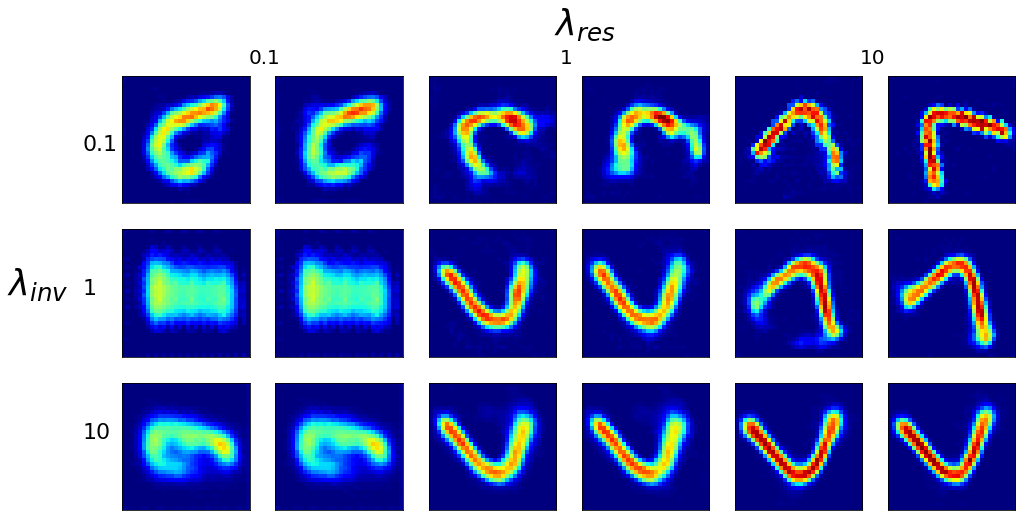

In [107]:
mpl_plotGridSearchResults(
    outputs,expnames_dict=get_expname_dict,
    lambda_inv_list=params, lambda_res_list=params, 
    copy_size=2,figsize=(16,8),
    savedir='./figs', savename='gridsearch_RI_mnist.pdf'
)

----------------------
## 4. SSIM, an estimator of single coordination (still in discussion)

In [87]:
def pkl_loader(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

In [102]:
filename="./pkl/62920647/ssim-mnist-62920647_patch2_deg10.pkl"

In [103]:
data = pkl_loader(filename)

In [104]:
data.keys()

dict_keys(['0', '1'])

In [112]:
a = data['1']

In [113]:
a.shape

(36,)

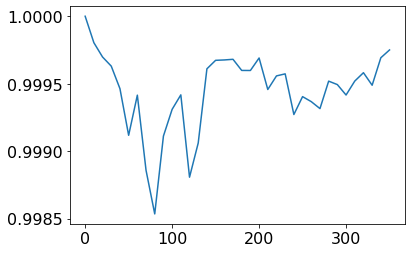

In [114]:
plt.figure()
plt.plot(np.arange(0,360,10), a)
plt.show()

In [115]:
np.min(a), np.max(a)

(0.99853414, 1.0)

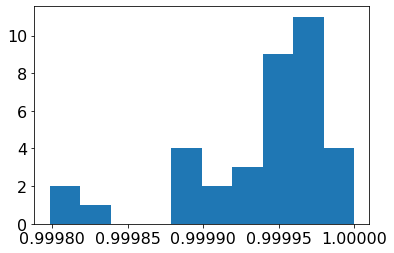

In [101]:
plt.figure()
plt.hist(a)
plt.show()

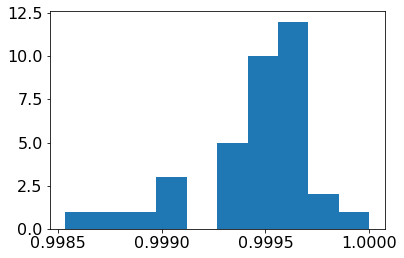

In [116]:
plt.figure()
plt.hist(a)
plt.show()

---------------------
### 5. Check if image is collapsed, canonical rotation or non-ri feature